\textbf{REDEME}:
1. This is an advanced version by combining more self-made primitive function in SR, which inherits from `DEAP CL Model 2D Class Inherit Version 1`. 
2. In this `jupyter notebook`, we are going to investigate the CL-SK, which could be found in Yamamoto's paper, though it is scaled with MPS. And the incident velocity is 1.9 MPS.
3. The CL-SK for tangential velocity is given by 
$$
R_{\mathrm{CLL, t}} = \frac{1}{\sqrt{\pi \sigma_t (2-\sigma_t)}} \times \mathrm{exp}\left\{-\frac{\left[V_{t, r}-(1-\sigma_t)V_{t, i}\right]^2}{\sigma_t(2-\sigma_t)}\right\} 
$$ where $\sigma_t$ is the thermal momentum accommodation coefficient (AC).
The CL-SK for normal velocity is given by
$$
R_{\mathrm{CLL, n}} = \frac{2 V_{n, r}}{\alpha_n} \times \mathrm{exp} \left\{-\frac{V_{n, r}^2+(1-\alpha_n)V_{n, i}^2}{ \alpha_n}\right\} \times I_0\left(\frac{2\sqrt{1-\alpha_n}V_{n, i}V_{n, r}}{\alpha_n}\right)
$$ where $\alpha_n$ is the AC of the normal kinetic energy.

4. Another point you need to keep in mind is that, all the data that are extracted from `SK_Data` folder should be scaled by MPS, i.e., velocity should divided by MPS and probability should be multiplied by MPS.
5. Actually, we got problems when fitting such data.

# Import Necessary Packages

In [1]:
import os

import time
import operator
import math
import random
import sympy
import multiprocessing
import numpy as np
import pandas as pd

# Plot the binary tree
import pygraphviz as pgv

import matplotlib.pyplot as plt
import scipy.special as special
from matplotlib.patches import Patch
from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy import integrate
from IPython.display import Image, display, Latex
from sklearn import metrics
from sklearn import model_selection

# from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
import sys
sys.path.append("../")
from utils import createDataDic  # Self-mdae function stored in python file

In [3]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)


# Data Preprocessing
## Tangential Part
###  Getting all Dataset Path 
During this process, we use self-made function to create a dictionary to store paths of our data. The key is the parent folder name, then the child key is the file name without some nonsense postfix, lastly, the child value is the path for specific text file.

In [4]:
current_abs_path = os.path.abspath('.')  # Current absolute path
total_folder_name = '../SK_Data'
data_dic = createDataDic(current_abs_path,
                         total_folder_name)  # Data path dictionary
list(data_dic["Maxwellian"].keys())

E:\School 4\BEng Mechanical Engineering Project\AiFeynmanTest\CLL_Kernel\../SK_Data\.DS_Store is a file


['incident_velocity_normal',
 'incident_velocity_tangential',
 'incident_velocity_tangential_x',
 'incident_velocity_tangential_y',
 'normal_ACs',
 'README',
 'reflected_normal_01',
 'reflected_normal_05',
 'reflected_normal_09',
 'reflected_normal_14',
 'reflected_normal_19',
 'reflected_Tx_01',
 'reflected_Tx_05',
 'reflected_Tx_09',
 'reflected_Tx_14',
 'reflected_Tx_19',
 'reflected_velocity_normal',
 'reflected_velocity_tangential',
 'reflected_velocity_tangential_x',
 'reflected_velocity_tangential_y',
 'tangential_ACs',
 'tangential_KEs',
 'x_meas_gas_full']

In [5]:
def extracData(folder_name, file_name):
    """
    This is a function to extract the data in corresponding file.
    Variables:
        folder_name: The name of the child folder, e.g., it is diffusiveWall here.
        file_name: The name of the file for the specific velocity
    Returns:
        v: The velocity of this text file.
        number: The number of melocules with the same velocity, v.
        prob: The probability of the velocity, v. 
    Note: All the return values have been converted to numpy ndarray.
    """
    data_path = data_dic[folder_name][file_name]  # The path of the data
    data = pd.read_csv(data_path, header=None, sep=" ")
    data_np = np.array(
        data)  # convert the data from pandas' datafframe to numpy ndarray

    # Extract the data
    v = data_np[:, 0]
    number = data_np[:, 1]
    prob = data_np[:, 2]

    return v, number, prob


FOLDER_NAME = "Maxwellian"  # Second child folder name
FILE_LIST = [
    'incident_velocity_normal', 'incident_velocity_tangential',
    'incident_velocity_tangential_x', 'incident_velocity_tangential_y',
    'normal_ACs', 'README', 'reflected_normal_01', 'reflected_normal_05',
    'reflected_normal_09', 'reflected_normal_14', 'reflected_normal_19',
    'reflected_Tx_01', 'reflected_Tx_05', 'reflected_Tx_09', 'reflected_Tx_14',
    'reflected_Tx_19', 'reflected_velocity_normal',
    'reflected_velocity_tangential', 'reflected_velocity_tangential_x',
    'reflected_velocity_tangential_y', 'tangential_ACs', 'tangential_KEs',
    'x_meas_gas_full'
]  # The list contains all needed file name

### Visualize the data
1. Key information for constants of methane
- kB: the Boltmann constant, 
- Tw: the temperature of the wall, 
- mi: the molecular mass of methane.
2. In this section, we plot the all probabilities in terms of different velocity components, i.e., normal velocity, tangential velocity and its magnitude. At the same time, we used the most probable speed $v_m$ to scale our velocity, where $v_m = \sqrt{\frac{2 k_B T_w}{m_i}}$, so that we could gain non-dimension value here.
3. During analysis, we would like to use Equation \ref{eq: CL-SK tangential} to plot the theoretical value, where $V_{t, r}$ is the tangential velocity of reflected molecules, $V_{t, i}$ is the tangential velocity of incident particles and $V_{t, i} = 1.9 \times v_m$, and $\sigma_t = 0.3023$ 
$$
R_{\mathrm{CLL, t}} = \frac{1}{\sqrt{\pi \sigma_t (2-\sigma_t)}} \times \mathrm{exp}\left\{-\frac{\left[V_{t, r}-(1-\sigma_t)V_{t, i}\right]^2}{\sigma_t(2-\sigma_t)}\right\} 
\label{eq: CL-SK tangential}
$$
which could be converted into analytical expression as follows, 
$$
R_{\mathrm{CLL, t}} = 0.7875 \times \mathrm{exp} \left\{-1.949(V_{t, x} - 0.698 V_i)^2 \right\} = 0.7875 \times \mathrm{exp}\left\{ - 1.949 (V_{t, x} - 2.52)^2 \right\}
\label{eq: Analytical CL-SK tangential}
$$

-------------------- Parameter 1:0.9138520121942662
-------------------- Parameter 2:1.652151665962675
-------------------- Parameter 3:2.693235091286205


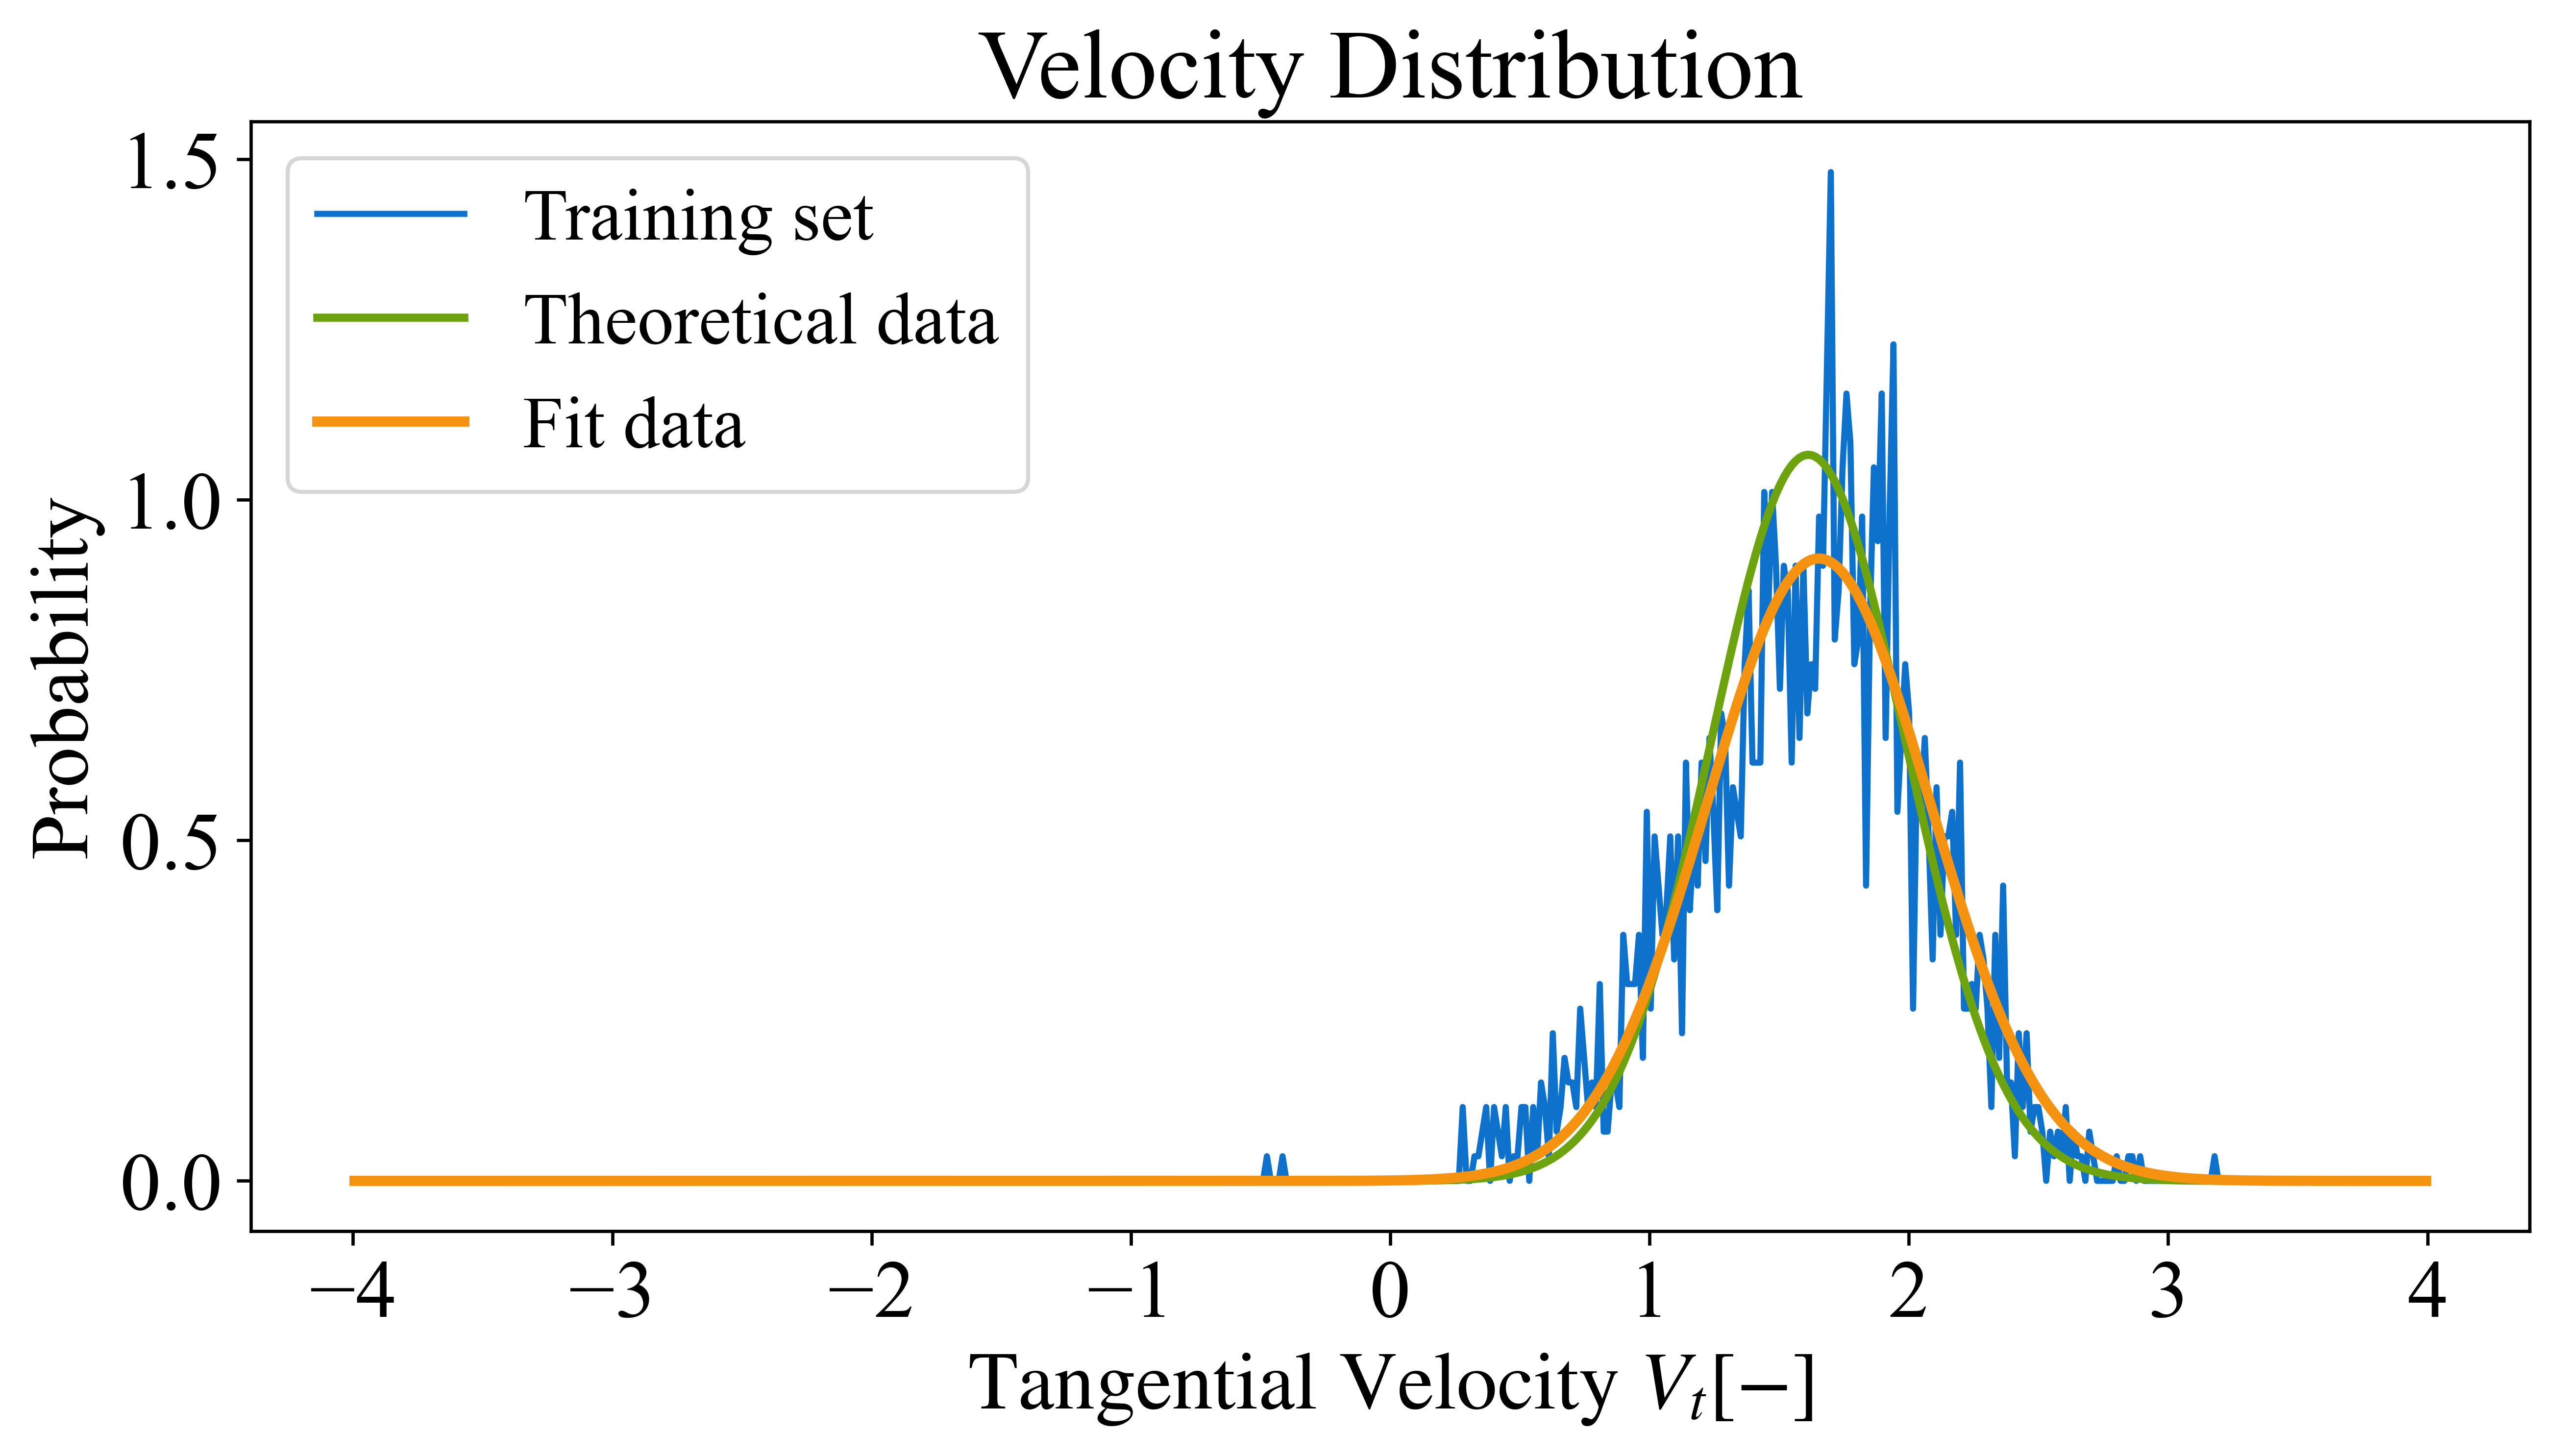

In [6]:
def calVm(parameters):
    """
    This is the function to calculate the most probable speed for methane. 
    Variables:
        Parameters: It is a dictionary that contains the properties of gas, the
            key is the name, value is the value of corresponding constant.
            kB: Boltzman const
            Tw: Temperature of the wall
            mi: Molecular mass fof methane
    Returns:
        Vm: The most probable speed.
        Vm0: Some times could be as reference, like Vm.
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    Vm = np.sqrt(2 * kB * Tw / mi)  # Most probable speed
    Vm0 = np.sqrt(kB * Tw / mi)  # reference velocity factor

    return Vm, Vm0


def theoDataTan(x):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    ------------------
    Notice, we use global varibale CHO_NUM_TX here.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """
    beta = sigmaT[CHO_NUM] * (2 - sigmaT[CHO_NUM])
    f = 1 / (np.sqrt(np.pi * beta)) * np.exp(
        -np.power(x - (1 - sigmaT[CHO_NUM]) * vincident[CHO_NUM], 2) / beta)

    return f


def theoDataNormal(x):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """
    alpha = np.complex(
        0, 2 * np.sqrt(1 - alphaN[CHO_NUM]) * vincident[CHO_NUM] /
        alphaN[CHO_NUM])

    beta = (1 - alphaN[CHO_NUM]) * np.square(
        vincident[CHO_NUM]) / alphaN[CHO_NUM]
    return 2 / alphaN[CHO_NUM] * x * np.exp(-np.power(x, 2) / alphaN[CHO_NUM] -
                                            beta) * special.jv(0,
                                                               alpha * x).real


def fitTan(x, A, B, C):
    return A * np.exp(-C * (x - B)**2)


def fitNormal(x, A, B, C, D):
    f1 = np.exp(B * x**2 + C)
    f2 = special.jv(0, np.complex(0, D) * x).real
    return A * x * f1 * f2

    
sigmaT = [0.3023, 0.2669, 0.2264, 0.1954,
          0.1515]  # All molecules - Partial TMAC
alphaN = [0.6139, 0.5666, 0.5000, 0.4439,
          0.4102]  # All molecules - Partial NKEAC
vincident = [0.1, 0.5, 0.9, 1.4,
             1.9]  # selected velocity magnitude (non-dimensionlised)
GAS_PROPERTIES = {
    'kB': 1.38064852e-23,
    'Tw': 423,
    'mi': 2.66389e-26
}  # The corresponding parameter of methane, kB is the Boltmann constant,
# Tw is the temperature of the wall, mi is the molecular mass of methane.

CHO_NUM = 4  # The chosen number in vincident, signmaT, alphaN list
key = "Tangential"
VM, _ = calVm(GAS_PROPERTIES)

if key == "Tangential":
    v, _, prob = extracData(FOLDER_NAME, FILE_LIST[11 + CHO_NUM])
    # Scale the data
    V = v / VM
    Y_TRAIN = prob * VM
    y_theo = theoDataTan(V)
    #     y_theo = 1 / integrate.simps(y_theo, V) * y_theo
    # Fit the data
    guess = [1, 0.5, 2.5]
    fit_para, _ = curve_fit(fitTan, V, Y_TRAIN, p0=guess)
    y_fit = fitTan(V, fit_para[0], fit_para[1], fit_para[2])
elif key == "Normal":
    v, _, prob = extracData(FOLDER_NAME, FILE_LIST[6 + CHO_NUM])
    # Scale the data
    V = v / VM
    Y_TRAIN = prob * VM
    y_theo = theoDataNormal(V)
    #     y_theo = 1 / integrate.simps(y_theo, V) * y_theo
    # Fit the data
    guess = [4, -2, -1, 2.546]
    fit_para, _ = curve_fit(fitNormal, V, Y_TRAIN, p0=guess)
    y_fit = fitNormal(V, fit_para[0], fit_para[1], fit_para[2], fit_para[3])

# Print fitting information

for i in range(len(fit_para)):
    print("{:-^20} Parameter ".format("") + str(i + 1) + ":" +
          str(fit_para[i]))

plt.figure(figsize=(10, 5), dpi=600)
plt.plot(V, Y_TRAIN, label="Training set", linewidth=1.5, c='#0e72cc')
plt.plot(V, y_theo, label='Theoretical data', linewidth=2, c='#6ca30f')
plt.plot(V, y_fit, label="Fit data", linewidth=2.5, c='#f59311')
if key == "Tangential":
    plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
elif key == "Normal":
    plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")

plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)

plt.show()

# DEAP Numpy
1. At the first stage, we use x_train and theo_y, i.e., the theoretical data without noise to test whether DEAP works for our idea. \textbf{NOTE}: The data structure is numpy.ndarray, which should be careful when creating corresponding  parts in DEAP. 
## DEAP SR Pipeline


In [7]:
# Tangential part
# A, B = V_TX.squeeze(), y_fit_tx.squeeze()#PROB_TX.squeeze()
VI = vincident[CHO_NUM]
vi_list = np.array([VI for _ in range(len(V))])
X_TRAIN = np.vstack((V, -vi_list)).T # 530 * 2 

In [8]:
"""Please note that, we change the definition of exponential function, which
could enhance the diversity of the model but also lead to no-solution problem."""

# Define new functions
def _protectedDiv(left, right):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
        exp_f = np.exp(x**2)
        return np.where(exp_f > 9e6, 0, exp_f)


def Bessel(x):
    try:
        alpha = np.array([np.complex(0, x_part) for x_part in x])
    except Exception as e:
        alpha = np.complex(0, x)
    return special.jv(0, alpha).real


def createPset(key):
    pset = gp.PrimitiveSet("MAIN", 2)
    pset.addPrimitive(np.add, 2, name="add")
    pset.addPrimitive(np.subtract, 2, name="sub")
    pset.addPrimitive(np.multiply, 2, name="mul")
    pset.addPrimitive(_protectedDiv, 2, name="div")
#     pset.addPrimitive(np.square, 1, name='square')
    pset.addPrimitive(_protectedExp, 1, name="exp")
#     pset.addPrimitive(np.negative, 1, name="neg")
    if key == "Normal":
        pset.addPrimitive(Bessel, 1, name="I0")

    pset.addEphemeralConstant(
        "rand_round", lambda: np.round_(random.uniform(0, 2), decimals=3))

    pset.renameArguments(ARG0='x')
    pset.renameArguments(ARG1='y')

    return pset

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [16]:
def varAnd(population, toolbox, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover **and** mutation). The modified individuals have their
    fitness invalidated. The individuals are cloned so returned population is
    independent of the input population.
    -------------------
    Variables: 
        :param population: A list of individuals to vary.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the 
                evolution operators.
        :param cxpb: The probability of mating two individuals. 
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple 
                    mutation mechanism. The key tis the muytation way, the value
                    is the mutation probability.
    ------------------
    :returns: A list of varied individuals that are independent of their
              parents.
    """
    offspring = [toolbox.clone(ind) for ind in population]

     # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb["subtree"]:
            offspring[i - 1], offspring[i] = toolbox.mate(
                offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
        elif (random.random() >= cxpb["subtree"]) and (
                random.random() < cxpb["subtree"] + cxpb["leaf"]):
            offspring[i - 1], offspring[i] = toolbox.p_leaf_cx(
                offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    prob_cx = cxpb["subtree"] + cxpb["leaf"]
    prob_middle = prob_cx + mutpb["full"]
    prob_last = prob_cx + mutpb["full"] + mutpb["grow"]
    for mut_name in list(mutpb.keys()):
        if mut_name == 'full':
            for i in range(len(offspring)):
                if (random.random() >= prob_cx) and (random.random() <
                                                     prob_middle):
                    offspring[i], = toolbox.mutate_full(offspring[i])
                    del offspring[i].fitness.values
        else:
            for i in range(len(offspring)):
                if (random.random() >= prob_middle) and (random.random() <
                                                         prob_last):
                    offspring[i], = toolbox.mutate_grow(offspring[i])
                    del offspring[i].fitness.values

    return offspring


def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    -----------------
    Variables:
        :param population: A list of individuals.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                        operators.
        :param cxpb: The probability of mating two individuals.
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple
                    mutation mechanism. The key tis the muytation way, the 
                    value is the mutation probability.
        :param ngen: The number of generation.
        :param stats: A :class:`~deap.tools.Statistics` object that is updated
                      inplace, optional.
        :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                           contain the best individuals, optional.
        :param verbose: Whether or not to log the statistics.
    ----------------
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        # Set stopping criteria
        if record['fitness']['min'] < 0.0001:
            print('The stopping criteria is met, with fitness {}'.format(record['fitness']['min']))
            break 

    return population, logbook, record


In [17]:
class BaseSymReg():
    """creator has been treated as global one.
    --------------------------------
    Variables:
        _Data_info: Dictionary
            It should be the structure like the following example, 
            Data_info = {
                "X_train": X_TX,  # training  X, m*2, where m is number of sampling points.
                "y_train": PROB_TX,  # training y
                "fit": y_fit_normal,  # fit data, but for empirical data, it could be None
                "fit_para": fit_parameters_normal,  # same as before
                "theoretical": y_theo_normal,  # theoretical data, should be None for real
            }
            Here it contains the X, y we want to fit in our job. 
        _mutation_dic: Dictionary
            It should be the structure like *mutation_dic = {'full': 0.05, 'grow': 0.1}*.
            Since we only include two mutation tree generation ways, i.e., full
            and grow, the mutation probability should noly be the configuration
            like this.
        _pset: `gplean.gp.PrimitiveSet`
            It is a primitive set containing all the functions, variables and
            constant.
        save_path: string
            It is a path to save the comparison figure.
        _generation: int, default as 20
            The generation number.
        _penelty_coeff: list, default as [0, 0.001, 0.001]
            It is the coefficient before our L2 regularization, i.e., integration
            penalty.
        _height_max_value: int, default as 4
            It controls bloat problem in SR. The value here means the maximum
            length of the deepest tree.
        _pop_size: int, default as 2000
            The population size.
        _prob_cx_subtree: float, default as 0.5.
            Crossover action.
        _prob_cx_leaf: float, default as 0.1.
            Crossover action, but not the whole subtree.
        sk_kind: string
            There are two kinds of skcattering kernels, i.e. normal and
            tangential. In this class, we only accept `Normal` and `Tangential` 
            as our key word to do some analysis.
    -------------------
    NOTE: There are two global variable in this class, i.e., A and B. 
        A is the X_train, B is the y_trian or any other knid of y value.
    """
    def __init__(self,
                 Data_info,
                 mutation_dic,
                 pset,
                 save_path,
                 generation=20,
                 population_size=2000,
                 height_max_value=4,
                 prob_cx_subtree=0.5,
                 prob_cx_leaf=0.1,
                 sk_kind="Normal",
                 penalty_coeff=[0, 0.001, 0.001]):
        self._Data_info = Data_info
        self._mutation_dic = mutation_dic
        self._pset = pset
        self.save_path = save_path
        self._generation = generation
        self._height_max_value = height_max_value
        self._pop_size = population_size
        self._prob_cx_subtree = prob_cx_subtree
        self._prob_cx_leaf = prob_cx_leaf
        self.sk_kind = sk_kind
        self._penelty_coeff = penalty_coeff

    def __del__(self):
        """We need to delete the instance to release the memory."""
        print("The instance has been deleted")

    def assembleGP(self, ):
        toolbox = base.Toolbox()

        toolbox.register("expr",
                         gp.genHalfAndHalf,
                         pset=self._pset,
                         min_=1,
                         max_=6)
        toolbox.register("individual", tools.initIterate, creator.Individual,
                         toolbox.expr)
        toolbox.register("population", tools.initRepeat, list,
                         toolbox.individual)
        toolbox.register("compile", gp.compile, pset=self._pset)

        def evalSymbReg(individual, points, y_true):
            """At this function, we must consider so many exceptions for
            integration.
            ---------
                Points: m*2, m is the number of sampling points.
            """
            m, _ = points.shape
            # Transform the tree expression in a callable function
            func = toolbox.compile(expr=individual)
            # Evaluate the mean squared error between the expression
            y_pred = func(points[:, 0], points[:, 1])
            numerator = np.sum((y_true - y_pred)**2)
            error = np.sqrt(numerator) / m # MSE
#             denominator = np.sum((y_true - np.average(y_true))**2)
#             error = np.sqrt(numerator / denominator) / m
            # Probability should be larger than zero

            if np.array(y_pred < 0.0).any():
                P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
            else:
                P_1 = 0.0

            # Integration constraint
            try:
                """Sometimes the function could be a number."""
                inte = integrate.simps(y_pred, points[:, 0])
            except Exception as e:
                inte = y_pred * (np.max(points[:, 0]) - np.min(points[:, 0]))
            finally:
                with np.errstate(over='ignore'):
                    # P_2 = (inte - 1)**2
                    P_2 = np.abs(inte-1)
            # Detailed balance
            if self.sk_kind == "Tangential":
                left = np.exp(-points[:, 1]**2) * func(points[:, 0], points[:,
                                                                            1])
                right = np.exp(-points[:, 0]**2) * func(
                    -points[:, 1], -points[:, 0])
                P_3 = np.sqrt(np.sum((left-right)**2))
#                 P_3 = np.sqrt(np.average((left - right)**2))
#                 P_3 = np.average(np.abs(left - right))
            elif self.sk_kind == "Normal":
                left = np.abs(points[:, 1]) * np.exp(-points[:, 1]**2) * func(
                    points[:, 0], points[:, 1])
                right = points[:, 0] * np.exp(-points[:, 0]**2) * func(
                    -points[:, 1], -points[:, 0])
                with np.errstate(over='ignore'):
                    P_3 = np.sqrt(np.sum((left-right)**2))
#                     P_3 = np.sqrt(np.average((left-right)**2))
#                     P_3 = np.average((left - right)**2)
            else:
                raise ("Please Input Valid SKs Type during Creating Instance!")
            errors = error + self._penelty_coeff[0] * P_1 + self._penelty_coeff[
                1] * P_2 + self._penelty_coeff[2] * P_3

            return errors,

        # Fitness function
        toolbox.register("evaluate",
                         evalSymbReg,
                         points=self._Data_info["X_train"],
                         y_true=self._Data_info["y_train"])
        # Selection
        toolbox.register("select", tools.selTournament, tournsize=20)
        # Crossover
        toolbox.register("mate", gp.cxOnePoint)  # Subtree crossover
        toolbox.register("p_leaf_cx",
                         gp.cxOnePointLeafBiased,
                         termpb=self._prob_cx_leaf)  # leaf crossover
        # Mutation
        toolbox.register("expr_mut_full", gp.genFull, min_=0,
                         max_=3)  # The depth of leaf are strict constrainted
        toolbox.register("expr_mut_grow", gp.genGrow, min_=0,
                         max_=5)  # The depth is varying
        toolbox.register("mutate_full",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_full,
                         pset=self._pset)
        toolbox.register("mutate_grow",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_grow,
                         pset=self._pset)

        # Bloat control: It is useful for crossover and mutation
        toolbox.decorate(
            "mate",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_full",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_grow",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "p_leaf_cx",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))

        return toolbox

    def score(self, X, y, best_tree):
        """This is a test function to give R^2 value as the score, where
        R^2 = (1 - U/V), which means R^2 is higher when the model's performance
        is better.
        """ 
        func = gp.compile(str(best_tree), pset=self._pset)
        y_pred = func(X[:, 0], X[:, 1])
        
        try:
            return np.sqrt(np.sum((y - y_pred)**2) / (y_pred.shape[0] - 2))
        except:
            return 1

    def main_program(self):
        random.seed(0)

        # 1. Prepare toolbox
        toolbox = self.assembleGP()

        # 2. Getting population
        pop = toolbox.population(n=self._pop_size)
        hof = tools.HallOfFame(1)

        # 3. Prepare log information
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("min", np.min)

        # 4. Evolution
        pop, log, record = eaSimple(
            pop,
            toolbox,
            cxpb={"subtree":self._prob_cx_subtree, "leaf":self._prob_cx_leaf},
            mutpb=self._mutation_dic,
            ngen=self._generation,
            stats=mstats,
            halloffame=hof,
            verbose=False
        )  # record gives the minimum fitness of each generation

        return pop, log, hof, record

    def _timeTransfer(self, total_time):
        """Transfer time into minutes and seconds"""
        minute = total_time // 60
        second = total_time % 60

        return minute, second

    def treeTransfer(self, hof):
        """
        Transfer the optimal individual into symbolc expression using string
        format.
        ----------------------
        hof_tree_expr: It is a simplified symbolic mathematical expression.
        hof_tree: It is a gp.PrimitiveTree structure, which is not a string
            that could be compiled to a function using gp.compile. Thus you need
            to use str(hof_tree) so that you could compile it.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set

        hof_tree = gp.PrimitiveTree(hof)[0]
        hof_tree_str = str(gp.PrimitiveTree(hof)[0])
        hof_tree_expr = sympy.sympify(hof_tree_str, locals=converter)
        hof_tree_expr = sympy.simplify(
            hof_tree_expr)  # simplify the expression

        return hof_tree_expr, hof_tree

    def plotComparison(self, best_tree):
        """
        best_tree: It shoule be PrimitiveTree structure, which should be
            converted into str here, so that the compilation could be made.
        """

        X = self._Data_info["X_train"]
        x_1, x_2 = X[:, 0], X[:, 1]
        noised_y = self._Data_info["y_train"]
        best_func = gp.compile(str(best_tree), self._pset)
        best_y = np.array(best_func(x_1, x_2))
        try:
            best_y.shape[0]
        except:
            best_y = [best_y for _ in range(x_1.shape[0])]
 
        theo_y = self._Data_info["theoretical"]

        fig = plt.figure(figsize=(9, 6))
    
        plt.plot(x_1, noised_y, label='Training set', linewidth=1.5, c='#0e72cc')
        plt.plot(x_1, theo_y, label="Theoretical data", linewidth=2, c='#6ca30f')
        plt.plot(x_1, best_y, label="Symbolic Data", c='#f59311')
        if self.sk_kind == "Normal":
            plt.xlabel('$\mathrm{Normal\ Velocity}\ V_n[-]$')
        elif self.sk_kind == "Tangential":
            plt.xlabel('$\mathrm{Tangential\ Velocity}\ V_t[-]$')
        else:
            plt.xlabel("$\mathrm{Velocity}\ V[-]$")

        plt.ylabel('Probability')
        plt.title('Velocity Distribution')
        plt.legend(fontsize=18, loc=0)

        plt.savefig(self.save_path)
        plt.show()

        theo_r2 = self.score(X, theo_y, best_tree)
        print("Theoretical SEOE = {:.3f}".format(theo_r2))
        training_r2 = self.score(X, noised_y, best_tree)
        print("Training SEOE = {:.3f}".format(training_r2))

    def treePlot(self, best_tree, path):
        nodes, edges, labels = gp.graph(best_tree)
        g = pgv.AGraph(ranksep="0.3", directed=True, strict=True)
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        g.layout(prog="dot")

        for i in nodes:
            node = g.get_node(i)
            # node.attr["label"] = labels[i]
            if isinstance(labels[i], float) or isinstance(labels[i], int):
                node.attr["label"] = np.round_(labels[i], decimals=3)
                node.attr['color'] = 'blue'
            else:
                node.attr["label"] = labels[i]
                if len(labels[i]) > 1:
                    node.attr['color'] = 'red'
                else:
                    node.attr['color'] = 'blue'

        g.draw(path)
        display(Image(path, height=150))
 

In [12]:
pset = createPset(key)

In [13]:
"""Here, we changed the height_max_value to 5 instead of 4, so the bloat control 
is changed."""

class AdvancedSR(BaseSymReg):
    def __init__(self, Data_info, mutation_dic, pset, fig_path, tree_path,
            gene_size=3, pop_size = 5000, prob_cx_subtree=0.5, sk_kind="Tangential",
            penalty_list=[0, 0.04, 0.2]):
        super().__init__(Data_info, mutation_dic, pset, fig_path, population_size=2000,
            generation=gene_size, prob_cx_subtree=prob_cx_subtree, sk_kind=sk_kind,
            penalty_coeff=penalty_list, height_max_value=5)
        self.tree_path = tree_path
        self._pset = pset
        self._vi = Data_info["vincident"]
        
    def leftHand(self, function, V):
        if self.sk_kind == "Tangential":
            return np.exp(-V[:, 1]**2) * function(V[:, 0], V[:, 1])
        else:
            return np.abs(V[:, 1])*np.exp(-V[:, 1]**2)*function(V[:, 0], V[:, 1])

    def rightHand(self, function, V):
        if self.sk_kind == "Tangential":
            return np.exp(-V[:, 0]**2) * function(-V[:, 1], -V[:, 0])
        else:
            return V[:, 0] * np.exp(-V[:, 0]**2) * (function(-V[:, 1], -V[:, 0]))
    
    def mainRun(self):
        # Time counting starts
        time_start = time.time()
        
        # 1. Run evolutionary program
        pop, log, hof, record = BaseSymReg.main_program(self)
        # 2. Obtain the best 
        best_sr_expr, best_tree = BaseSymReg.treeTransfer(self, hof)
        # 3. Plot the data
        BaseSymReg.plotComparison(self, best_tree)
        # 4. Display the expression
        display(best_sr_expr)  
        # 5. Plot the tree structure
        BaseSymReg.treePlot(self, best_tree, self.tree_path)
        
        # Time ending 
        time_end = time.time()
        total_time = time_end - time_start
        print("Total Time: {:.3f} s".format(total_time))

        return best_tree
    
    def reciprocityCon(self, best_tree):
        if self.sk_kind == "Tangential":
#             vi = vincident[CHO_NUM]
            func = gp.compile(str(best_tree), pset=self._pset)
            a = np.linspace(-4, 4, num=100)
            b = np.array([self._vi for i in range(len(a))])
            train_x = np.vstack((a, -b)).T
        else:
#             vi = vincident[CHO_NUM]
            func = gp.compile(str(best_tree), pset=pset)
            a_n = np.linspace(0.007, 4, num=100)
            b_n = np.array([self._vi for i in range(len(a_n))])
            train_x = np.vstack((a_n, -b_n)).T

        lefthand = self.leftHand(func, train_x)
        righthand = self.rightHand(func, train_x)

        fig = plt.figure(figsize=(9, 6))
        plt.plot(train_x[:, 0], lefthand, label="left hand", c='red')
        plt.scatter(train_x[:, 0], righthand, label="right hand")
        plt.ylabel("Probability")
        plt.title("Reciprocity Relation")
        if self.sk_kind == "Tangential":
            plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
#             plt.savefig("./DEPA CL tangential detailed balance")
        else:
            plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
#             plt.savefig("./DEPA CL normal detailed balance")
        plt.legend(fontsize=18)
        plt.show()
    

In [14]:
def calculateFitness(best_tree, X, y):
    m, _ = X.shape
    # Transform the tree expression in a callable function
    func = gp.compile(str(best_tree), pset)
    # Evaluate the mean squared error between the expression
    y_pred = func(X[:, 0], X[:, 1])
    numerator = np.sum((y - y_pred)**2)
    error = np.sqrt(numerator) / m
    #     denominator = np.sum((PROB_NORMAL - np.average(PROB_NORMAL))**2)
    #     error = np.sqrt(numerator / denominator) / m
    # Probability should be larger than zero

    if np.array(y_pred < 0.0).any():
        P_1 = np.average(np.abs(y_pred[y_pred < 0.0]))
    else:
        P_1 = 0.0

    # Integration constraint
    try:
        """Sometimes the function could be a number."""
        inte = integrate.simps(y_pred, X[:, 0])
    except Exception as e:
        inte = y_pred * (np.max(X[:, 0]) - np.min(X[:, 0]))
    finally:
        with np.errstate(over='ignore'):
            P_2 = np.abs(inte - 1)
    # Detailed balance
    if key == "Tangential":
        left = np.exp(-X[:, 1]**2) * func(X[:, 0], X[:, 1])
        right = np.exp(-X[:, 0]**2) * func(-X[:, 1], -X[:, 0])
        P_3 = np.sqrt(np.sum((left - right)**2))
    elif key == "Normal":
        left = np.abs(X[:, 1]) * np.exp(-X[:, 1]**2) * func(X[:, 0], X[:, 1])
        right = X[:, 0] * np.exp(X[:, 0]**2) * func(-X[:, 1], -X[:, 0])
        with np.errstate(over='ignore'):
            P_3 = np.sqrt(np.sum((left - right)**2))
    print(
        "Fitness information: ---------- \n Error: {:<20} \n P_1: {:<20} \n P_2: {:<20} \n P_3: {:<20}"
        .format(error, P_1, P_2, P_3))

---------------------------------------0----------------------------------------
The instance has been deleted


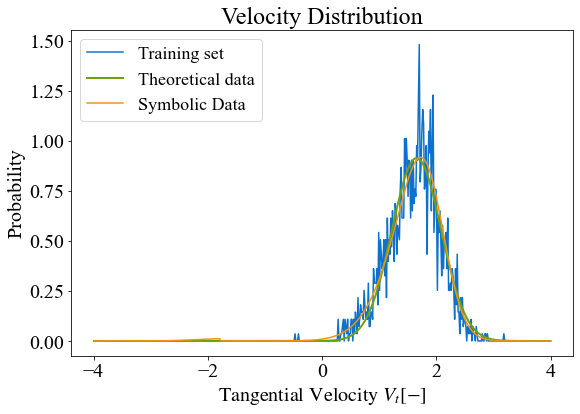

Theoretical SEOE = 0.022
Training SEOE = 0.072


1.38*exp(y**2 - 0.181569*(x + y)**2)/((0.5*exp(x**2) + exp(y**2) + 39.7480586136716)*exp((x + y)**2) - exp((y + 0.023)**2))

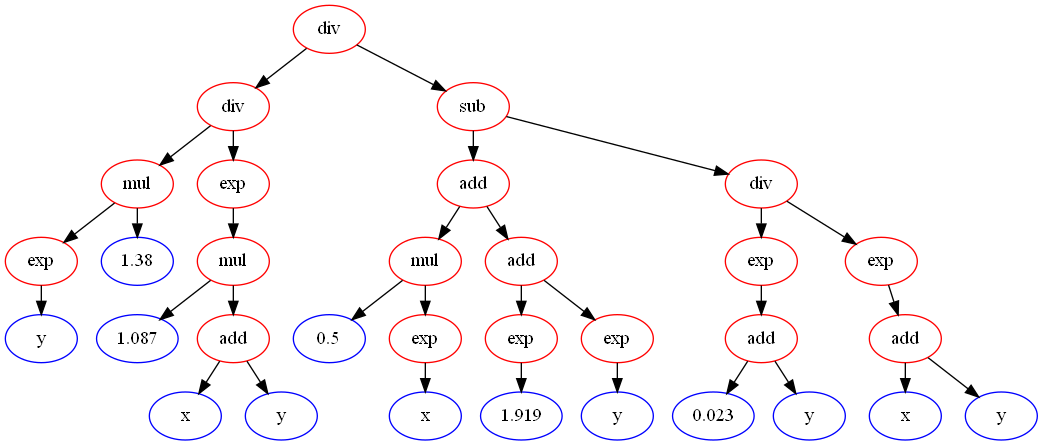

Total Time: 339.441 s


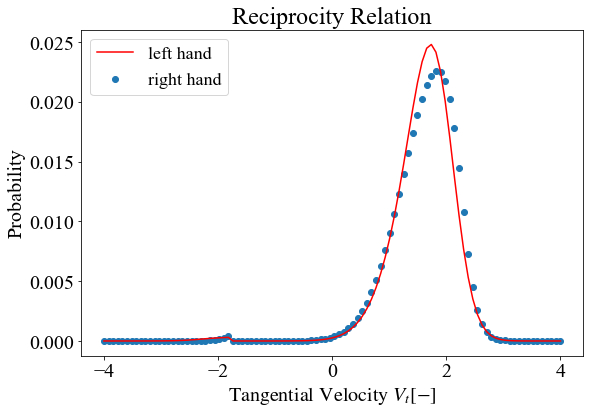

Fitness information: ---------- 
 Error: 0.0009671761632732863 
 P_1: 0.0                  
 P_2: 0.01547331303581978  
 P_3: 0.023801262580658133
--------------------------------------0.5---------------------------------------
The instance has been deleted


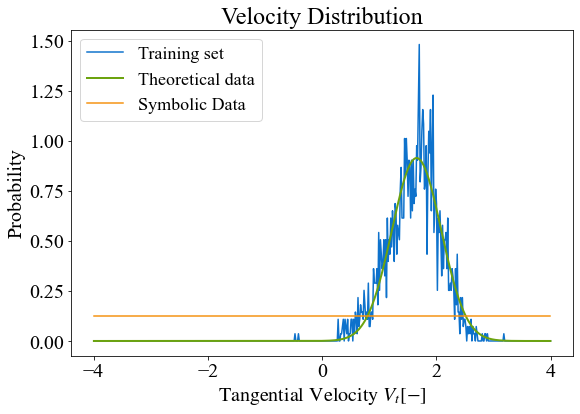

Theoretical SEOE = 0.254
Training SEOE = 0.265


-0.8*y**2*exp(-7.151762*(0.528820729772607*y + 1)**2)/(1.006*y - 21.1578077896556)

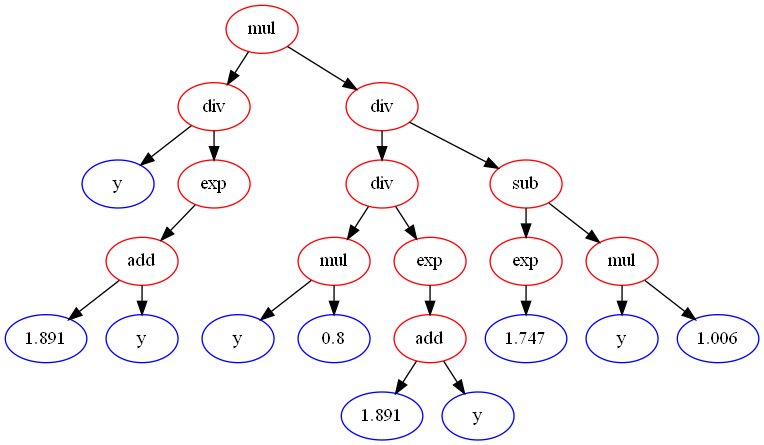

Total Time: 194.956 s


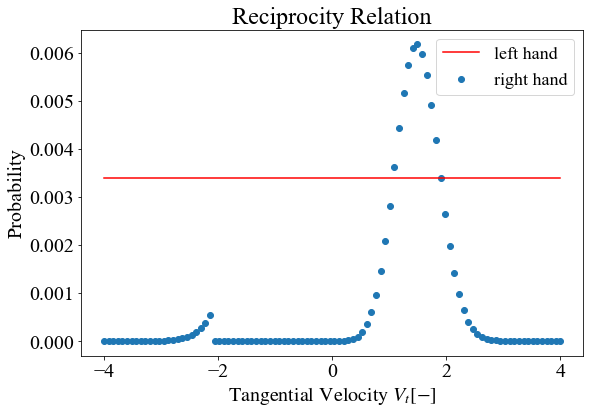

Fitness information: ---------- 
 Error: 0.011030046118987571 
 P_1: 0.0                  
 P_2: 4.323979348419549e-05 
 P_3: 0.0713772870138836  
--------------------------------------0.1---------------------------------------
The instance has been deleted


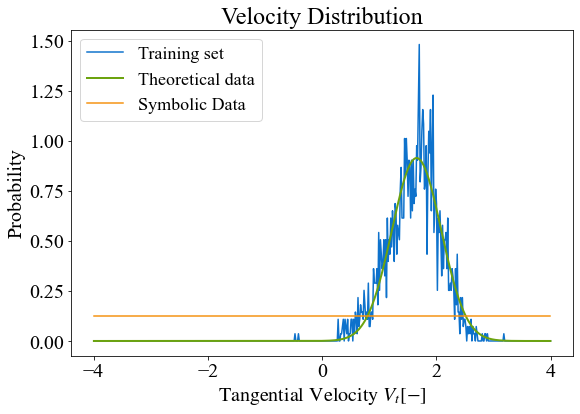

Theoretical SEOE = 0.254
Training SEOE = 0.265


(0.0181181782044*exp(y**2) + 0.439)*exp(-3.568321*(0.114830409579758*y + 1)**2)

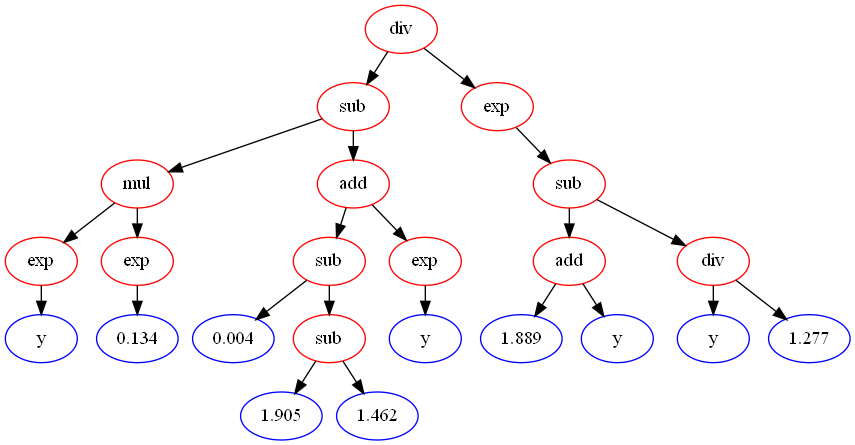

Total Time: 271.194 s


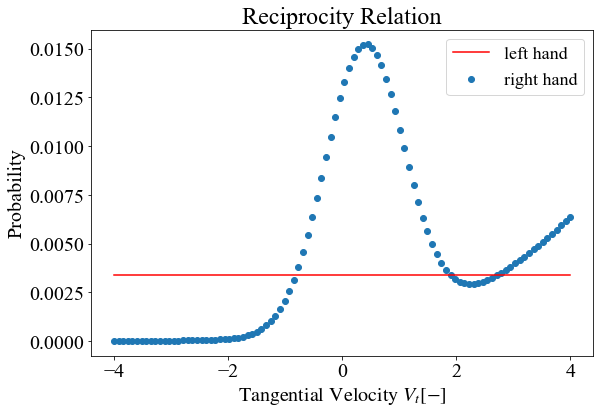

Fitness information: ---------- 
 Error: 0.011030054712189357 
 P_1: 0.0                  
 P_2: 0.0001714435550206339 
 P_3: 0.1104166559159699  
--------------------------------------0.05--------------------------------------
The instance has been deleted


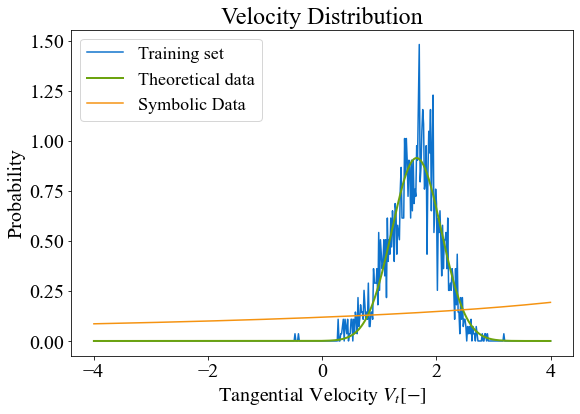

Theoretical SEOE = 0.248
Training SEOE = 0.259


exp(y**2)/(13.8427464008859*x*(y - 0.336) + x + y + 313.199833333333)

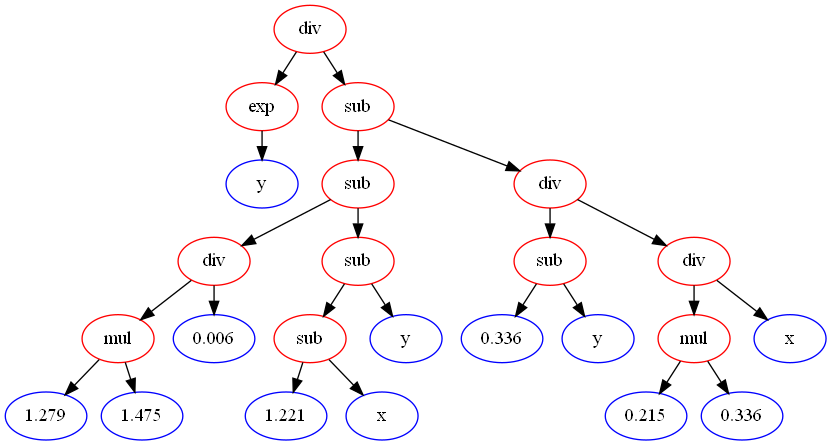

Total Time: 245.312 s


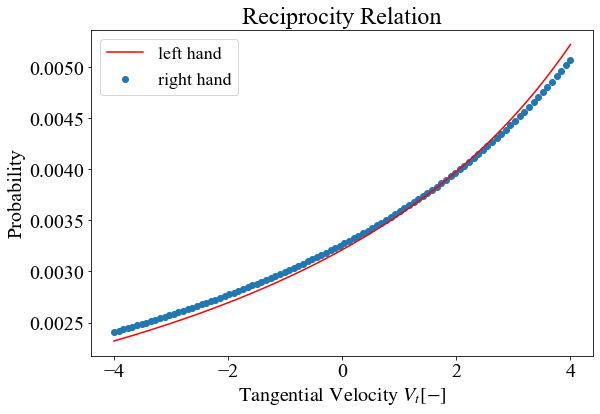

Fitness information: ---------- 
 Error: 0.010757385467968056 
 P_1: 0.0                  
 P_2: 5.085983231012392e-06 
 P_3: 0.0015577073944667915
--------------------------------------0.01--------------------------------------
The instance has been deleted


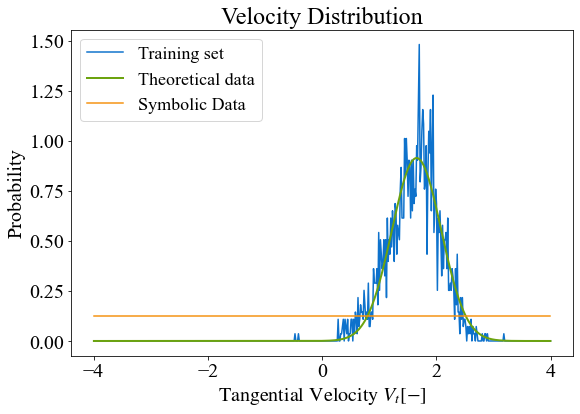

Theoretical SEOE = 0.254
Training SEOE = 0.265


0.00338617800770870

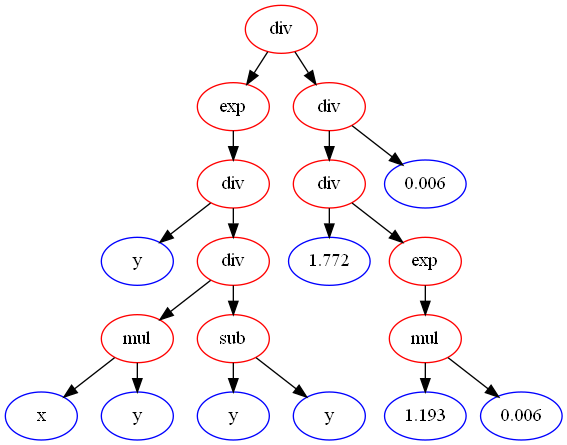

Total Time: 239.334 s


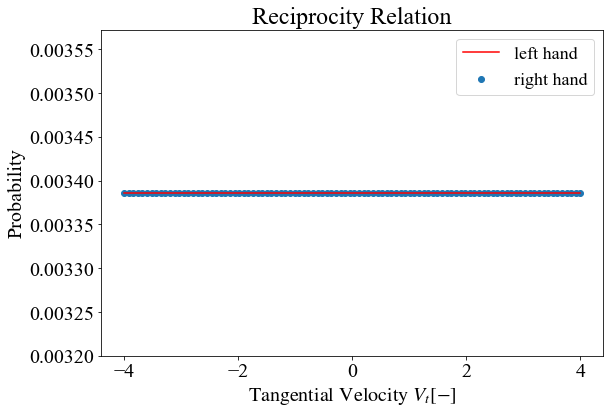

Fitness information: ---------- 
 Error: 0.011030047833667428 
 P_1: 0.0                  
 P_2: 1.5455258650654002e-07 
 P_3: 1.3850656231897365e-17
-------------------------------------0.005--------------------------------------
The instance has been deleted


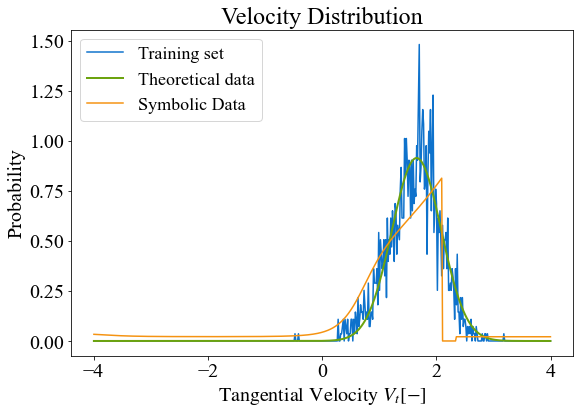

Theoretical SEOE = 0.110
Training SEOE = 0.126


(0.124*exp((x - y)**2) + 3.67593413449798)/(-71.4285714285714*y + exp(2.745649*(0.603500301750151*x + 1)**2) + 38.2552574308568)

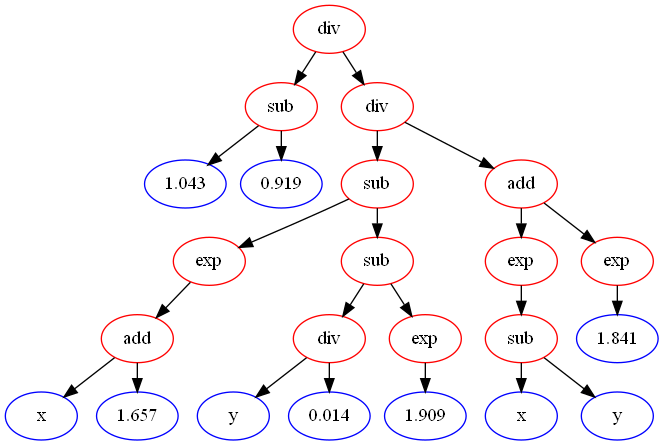

Total Time: 244.967 s


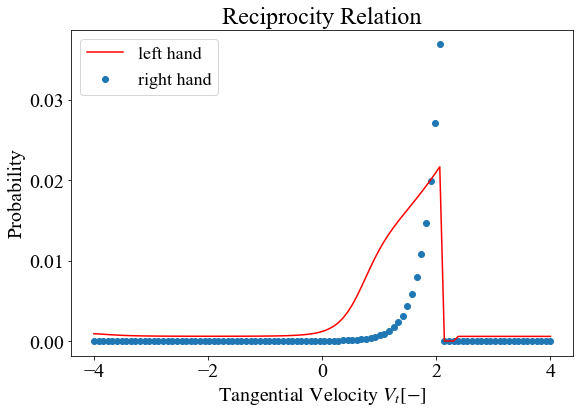

Fitness information: ---------- 
 Error: 0.004755790201554051 
 P_1: 0.0                  
 P_2: 0.0007061747661758488 
 P_3: 0.10281073969336608 
-------------------------------------0.001--------------------------------------
The instance has been deleted


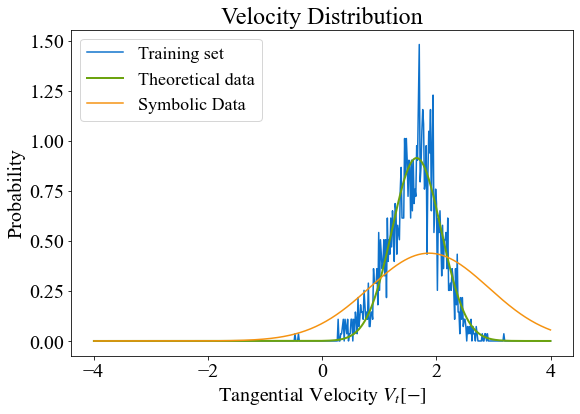

Theoretical SEOE = 0.161
Training SEOE = 0.178


(-0.01184*x + 0.01184*exp(y**2) + 0.02325376)*exp(-0.459222617093656*(x + y)**2)

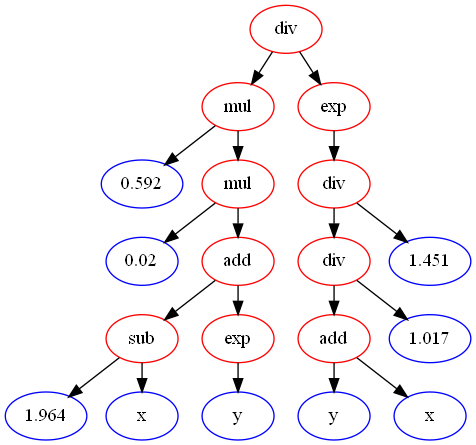

Total Time: 228.128 s


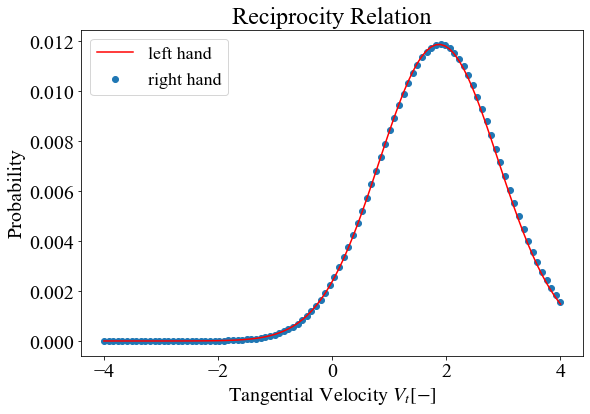

Fitness information: ---------- 
 Error: 0.006992059577515557 
 P_1: 0.0                  
 P_2: 0.12282669783524836  
 P_3: 0.0017648114015681256
-------------------------------------0.0005-------------------------------------
The instance has been deleted


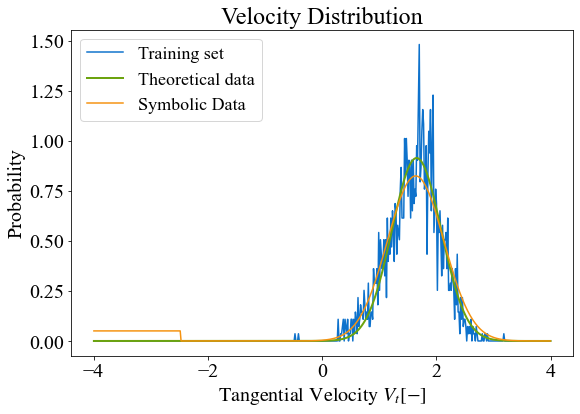

Theoretical SEOE = 0.037
Training SEOE = 0.083


-0.0249999999999999*(1.746472*y + 1.307)*(2*y - 1.521)*(x + 2*y - 1.184)*exp(-2.313441*(0.657462195923734*x - 1)**2 - (x + y)**2)

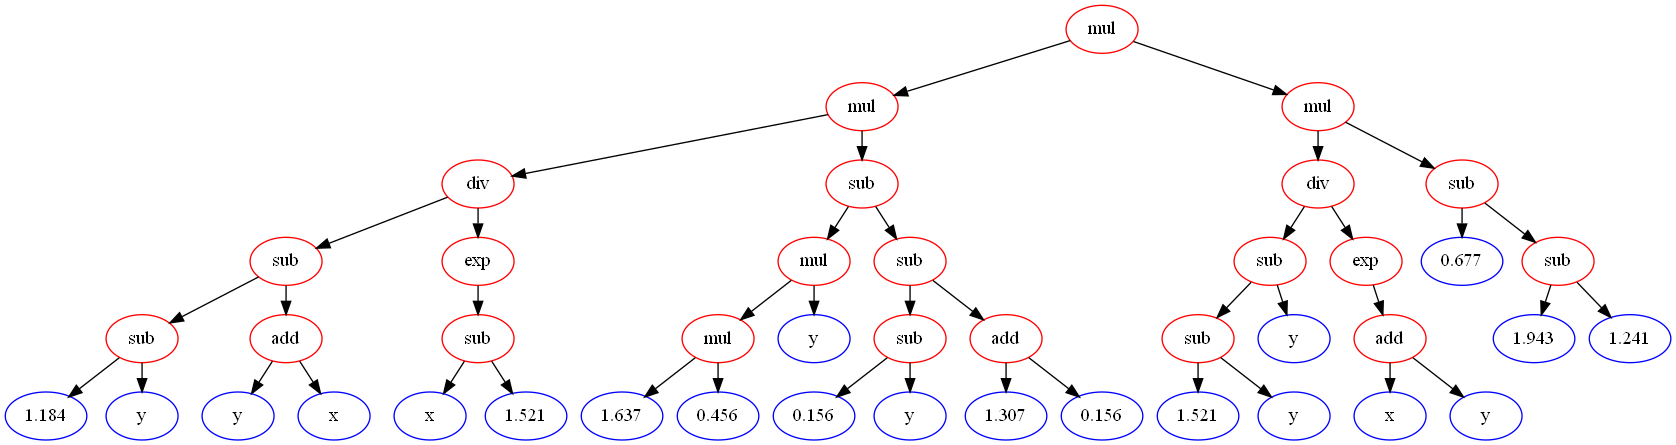

Total Time: 282.666 s


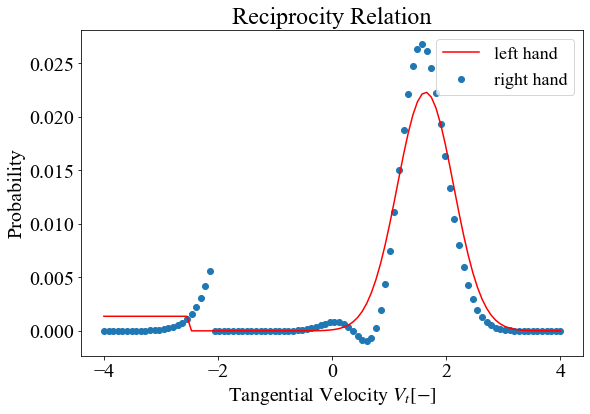

Fitness information: ---------- 
 Error: 0.0015938765215406572 
 P_1: 0.0                  
 P_2: 0.09793760614416902  
 P_3: 0.04404529594020352 
-------------------------------------0.0001-------------------------------------
The instance has been deleted


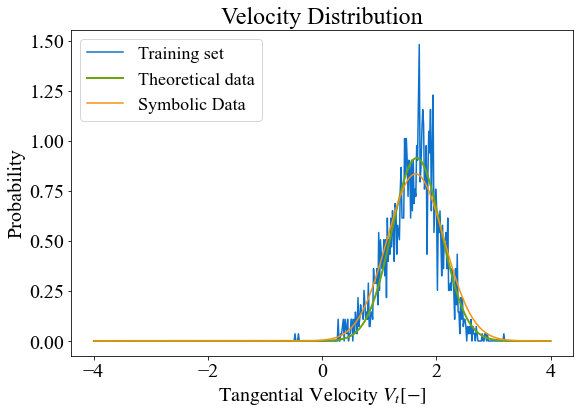

Theoretical SEOE = 0.031
Training SEOE = 0.081


(-0.0578545339532328*y - 0.021869013834322*(x - y)*(y + 1.301) + 0.021869013834322*exp(y**2))*exp(-1.855044*(0.734214390602056*x - 1)**2 - (x + y)**2)

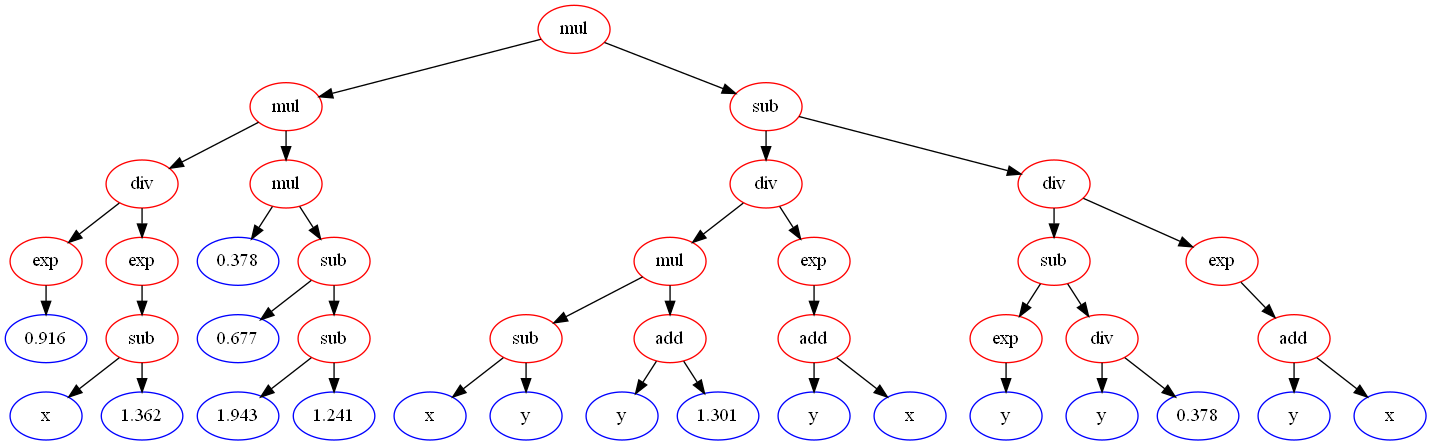

Total Time: 329.436 s


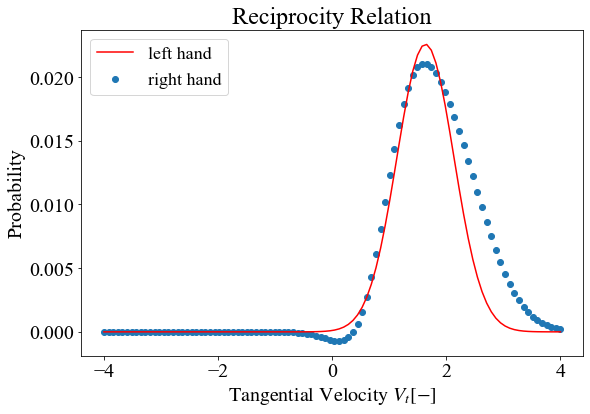

Fitness information: ---------- 
 Error: 0.0013312262244365486 
 P_1: 0.0                  
 P_2: 0.04604377587767394  
 P_3: 0.048830324129083114
-------------------------------------5e-05--------------------------------------
The instance has been deleted


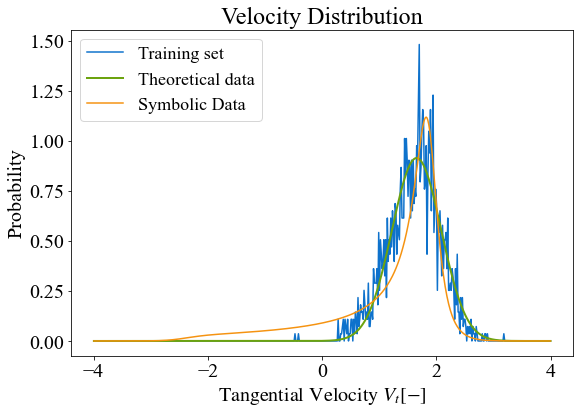

Theoretical SEOE = 0.098
Training SEOE = 0.107


(0.087*x - 0.97318*y)*(0.119*x - 0.97318*y)/(11.3218390804598*x*y + exp(x**2) - exp(1.929321*x**2*y**2*(0.719942404607631*y + 1)**2) + 38.1095154387839)

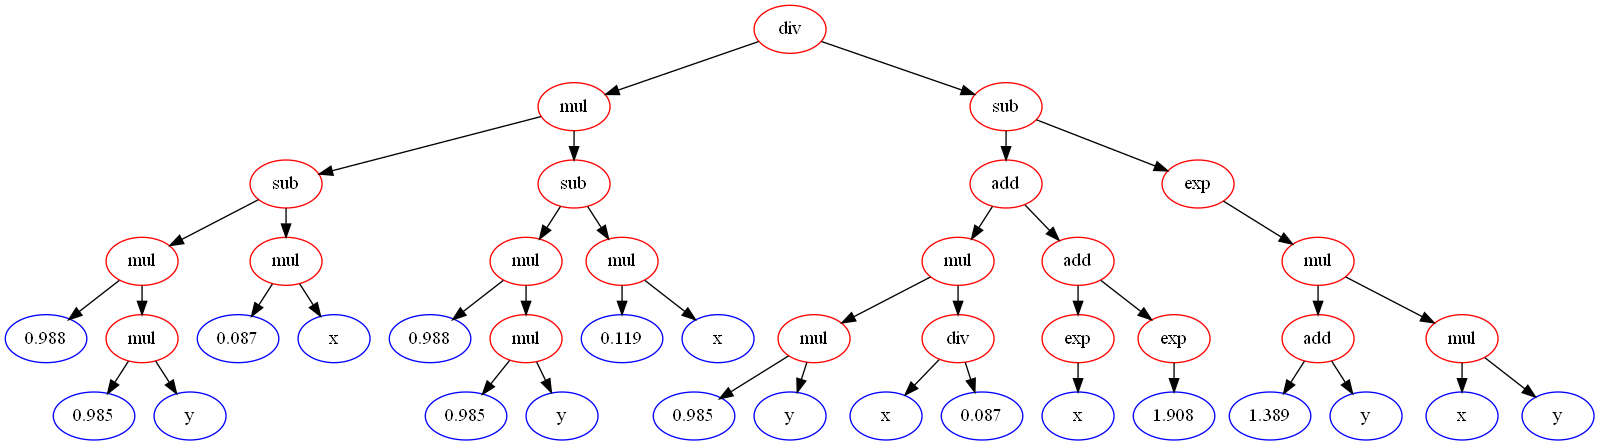

Total Time: 273.351 s


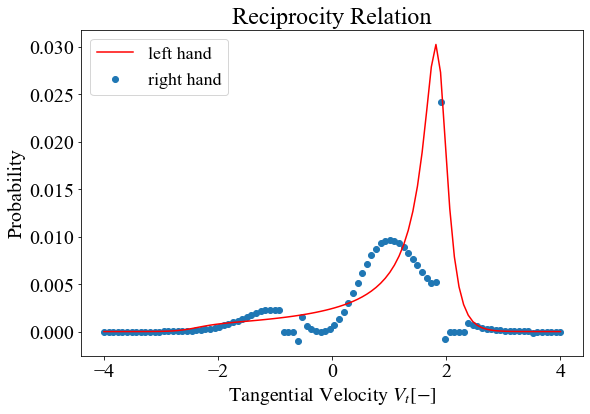

Fitness information: ---------- 
 Error: 0.004232914022721953 
 P_1: 0.0                  
 P_2: 0.0011176244924763212 
 P_3: 0.15367849812036177 
-------------------------------------1e-05--------------------------------------
The instance has been deleted


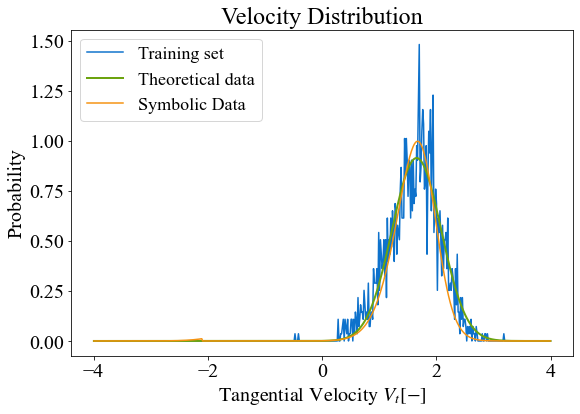

Theoretical SEOE = 0.044
Training SEOE = 0.083


exp(x**2 + y**2 - 2*(x + y)**2)/(x + (-1.974*x**2*y**2 + exp(x**2) + exp(y**2))*exp(x**2) - 1.997)

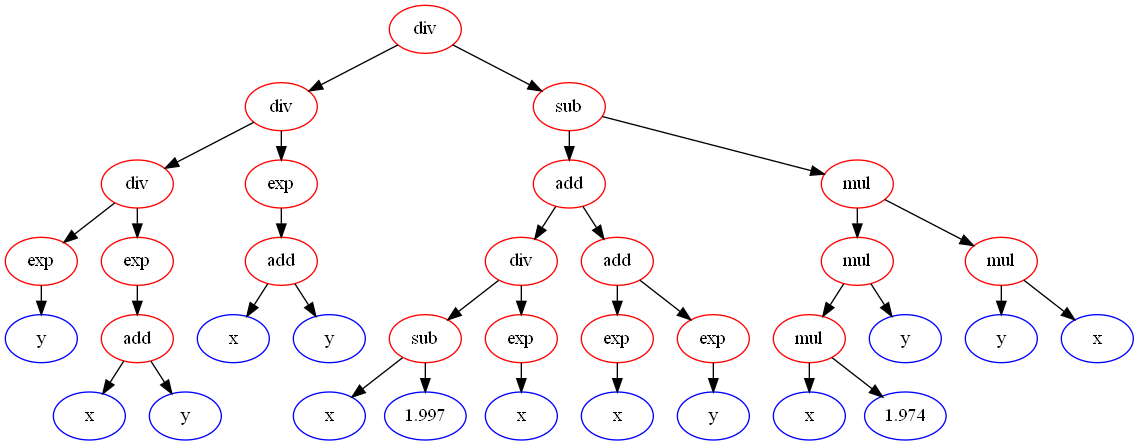

Total Time: 356.649 s


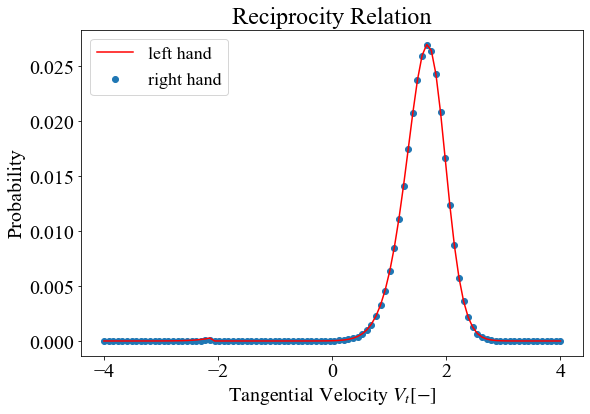

Fitness information: ---------- 
 Error: 0.001904748516157919 
 P_1: 0.0                  
 P_2: 0.12216516127412602  
 P_3: 0.0007823607974577426
-------------------------------------5e-06--------------------------------------
The instance has been deleted


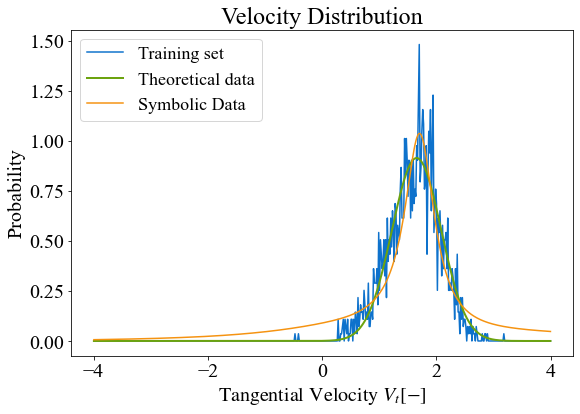

Theoretical SEOE = 0.070
Training SEOE = 0.095


(1.309*y + (0.234 - y)*exp(y**2))*(1.914*y + (0.245*x - y)*exp(y**2))*exp(-2*y**2 + (x + y)**2)/((9.43396226415094*x*(x + y) + exp(y**2) + 5.54824132964164)*exp((x + y)**2) - exp(y**2) + 0.657)

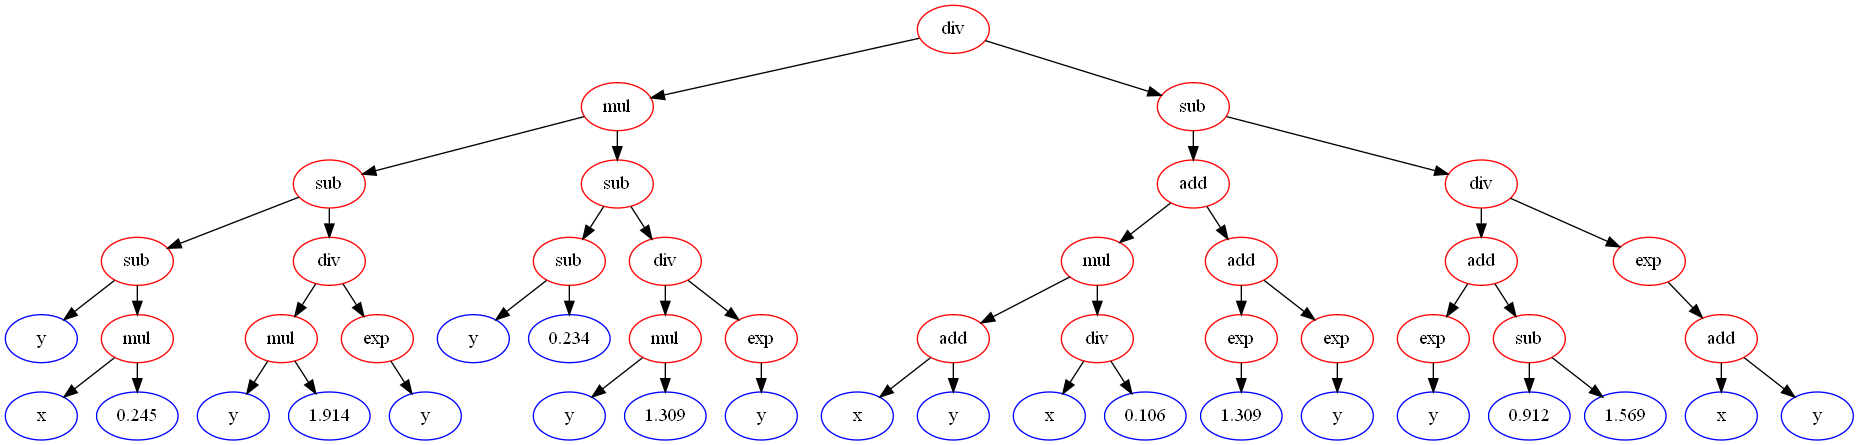

Total Time: 381.695 s


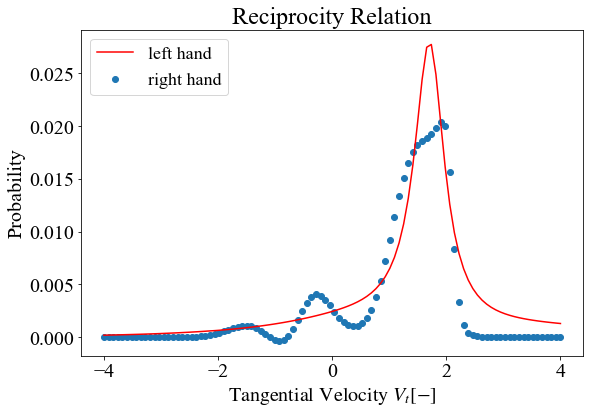

Fitness information: ---------- 
 Error: 0.0030450456598293176 
 P_1: 0.0                  
 P_2: 0.1851826087111883   
 P_3: 0.054685647665928094
-------------------------------------1e-06--------------------------------------
The instance has been deleted


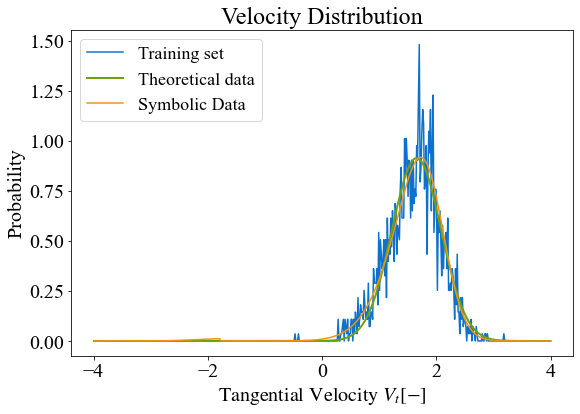

Theoretical SEOE = 0.022
Training SEOE = 0.072


1.38*exp(y**2 - 0.181569*(x + y)**2)/((0.5*exp(x**2) + exp(y**2) + 39.7480586136716)*exp((x + y)**2) - exp((y + 0.023)**2))

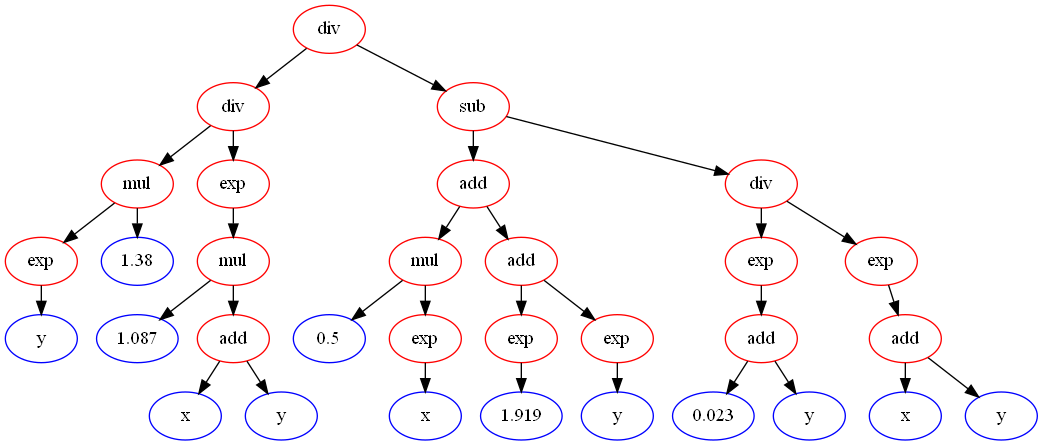

Total Time: 334.856 s


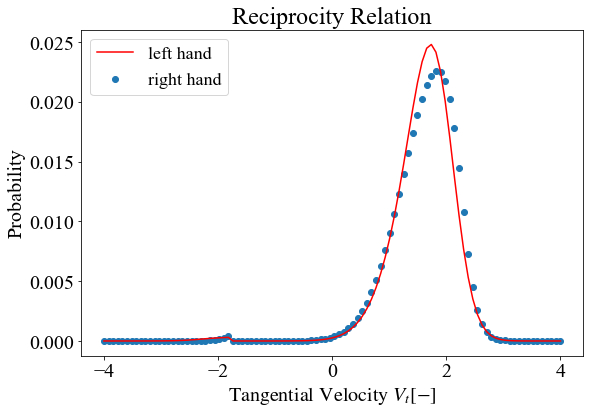

Fitness information: ---------- 
 Error: 0.0009671761632732863 
 P_1: 0.0                  
 P_2: 0.01547331303581978  
 P_3: 0.023801262580658133


In [21]:
if __name__ == "__main__":
    
    mutation_dic = {'full': 0.05, 'grow': 0.1}
    Data_info = {
        "X_train": X_TRAIN,
        "y_train": Y_TRAIN, #PROB_TX,  
        "vincident": VI,
        "theoretical": y_fit,
    }
    fig_path = './figure/DEMP_CL_Normal_Advanced_SR_Vi_19'
    tree_path = "./figure/DEAP_CL_Normal_tree_Advanced_SR_Vi_19.png"


    for num in [0, 0.5, 0.1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]:
#     for num in [8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5]:
        print("{:-^80}".format(num))
        advanceSR_object = AdvancedSR(Data_info=Data_info,
                                          mutation_dic=mutation_dic,
                                          pset=pset,
                                          fig_path=fig_path,
                                          tree_path=tree_path,
                                          gene_size=300, pop_size=10000, 
                                          prob_cx_subtree=0.6,
                                          sk_kind=key, 
                                          penalty_list=[1, num, 0.01]) #1, 0.001, 0.001
        best_tree = advanceSR_object.mainRun()
        advanceSR_object.reciprocityCon(best_tree)
        calculateFitness(best_tree, X_TRAIN, y_fit)

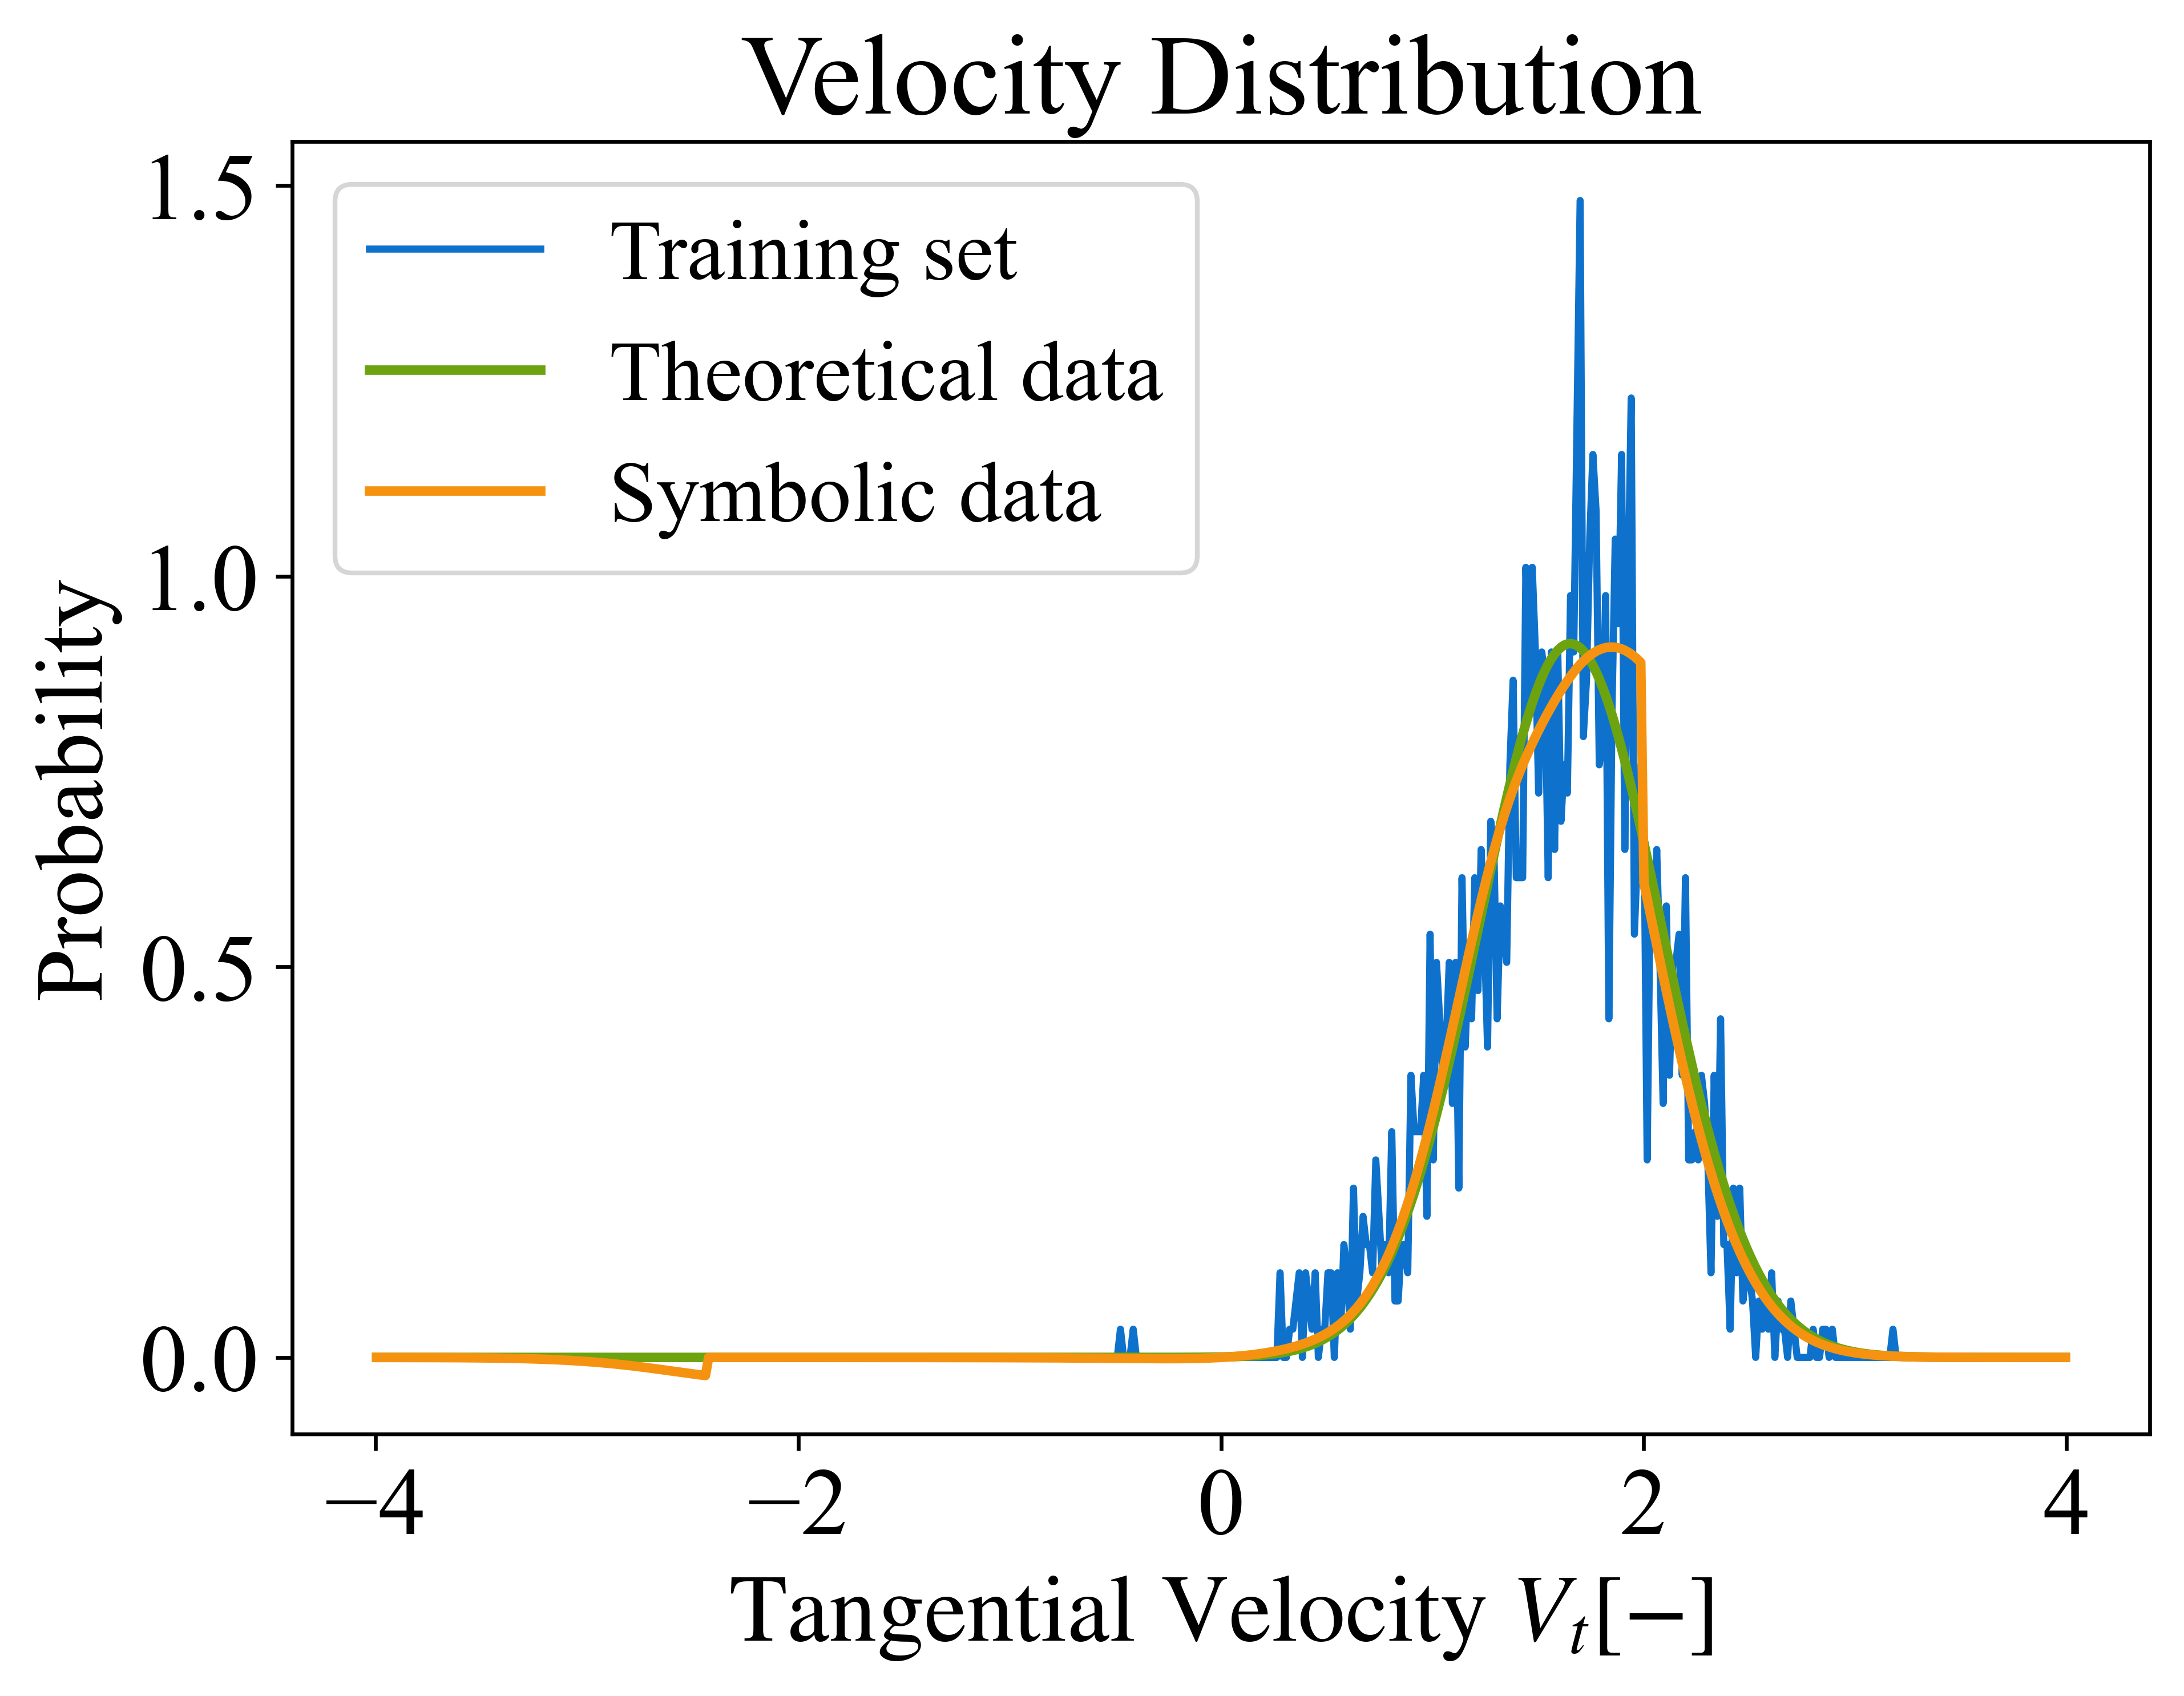

In [32]:
func = gp.compile(str(best_tree), pset)
y_sym = func(X_TRAIN[:, 0], X_TRAIN[:, 1])
fig = plt.figure(figsize=(7, 5), dpi=600)
plt.plot(X_TRAIN[:, 0], Y_TRAIN, label="Training set", c='#0e72cc')
plt.plot(X_TRAIN[:, 0], y_fit, label='Theoretical data', linewidth=2, c='#6ca30f')
plt.plot(X_TRAIN[:, 0], y_sym, label="Symbolic data", linewidth=2, c='#f59311')
if key == "Tangential":
    plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
elif key == "Normal":
    plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")

plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)
plt.savefig("./DEAP_CLL_Normal_Vi_19.png", bbox_inches="tight")

plt.show()

## Cross Validation

In [17]:
def plotCvIndices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape  # This should be pay attention when X is 2D
    else:
        m, _ = X.shape

    mask = {'train': {}, 'test': {}}  # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing
        indices[tr] = 0  # training
        mask['train'][str(ii + 1) + "_layer"] = tr
        mask['test'][str(ii + 1) + "_layer"] = tt

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices,
                   marker='_',
                   lw=lw,
                   cmap=cmap_cv,
                   vmin=-.2,
                   vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits) + 1)
    ax.set(yticks=np.arange(n_splits) + .5,
           yticklabels=yticklabels,
           ylim=[n_splits + 0.2, -.2],
           xlim=[0, m])  # the limit should be set
    ax.set_xlabel(xlabel='Sample index')
    ax.set_ylabel(ylabel="CV iteration")
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)

#     plt.savefig('./CrossValidation/CV_Tangential_vi_09.png')

    return ax, mask


def crossValidation(X, Y, n_splits=5):
    """In this class, A is the X, B is the y， A and B are all global variables, 
    should be modified. Here we use X and Y to replace A and B, respectively."""
    if X.ndim == 1:
        n_points, = X.shape
    else:
        n_points, _ = X.shape

    # Plot Sampling Graph
    fig, ax = plt.subplots(figsize=(6.5, 5), dpi=600)
    cv = model_selection.ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    percentiles_classes = [.2, .2, .6]
    y = np.hstack([[ii] * int(n_points * perc)
                   for ii, perc in enumerate(percentiles_classes)])
    groups = np.hstack([[ii] for ii in range(int(n_points))])

    # gain the mask and axes object
    ax, mask = plotCvIndices(cv, X, y, groups, ax=ax, n_splits=n_splits, lw=15)
    ax.legend([Patch(color=cmap_cv(.8)),
               Patch(color=cmap_cv(.1))], ['Testing set', 'Training set'],
              loc=(1.02, .8),
              fontsize=18)
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)
    fig.savefig('./CrossValidation/CV_Normal_vi_09.png', bbox_inches='tight')
    plt.show()

    # Extract the train and test data
    return mask["train"], mask["test"]


train_mask, test_mask = crossValidation(X_TX, y_fit_tx)
print("Training set spliting!")

NameError: name 'X_TX' is not defined

In [ ]:
def plotCvIndices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape  # This should be pay attention when X is 2D
    else:
        m, _ = X.shape

    mask = {'train': {}, 'test': {}}  # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing
        indices[tr] = 0  # training
        mask['train'][str(ii + 1) + "_layer"] = tr
        mask['test'][str(ii + 1) + "_layer"] = tt

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices,
                   marker='_',
                   lw=lw,
                   cmap=cmap_cv,
                   vmin=-.2,
                   vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits) + 1)
    ax.set(yticks=np.arange(n_splits) + .5,
           yticklabels=yticklabels,
           ylim=[n_splits + 0.2, -.2],
           xlim=[0, m])  # the limit should be set
    ax.set_xlabel(xlabel='Sample index')
    ax.set_ylabel(ylabel="CV iteration")
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)

    plt.savefig('./CrossValidation/CV_Tangential_vi_19.png', bbox_inches='tight')

    return ax, mask


def crossValidation(X, Y, n_splits=5):
    """In this class, A is the X, B is the y， A and B are all global variables, 
    should be modified. Here we use X and Y to replace A and B, respectively."""
    if X.ndim == 1:
        n_points, = X.shape
    else:
        n_points, _ = X.shape

    # Plot Sampling Graph
    fig, ax = plt.subplots(figsize=(7, 5), dpi=600)
    cv = model_selection.ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    percentiles_classes = [.2, .2, .6]
    y = np.hstack([[ii] * int(n_points * perc)
                   for ii, perc in enumerate(percentiles_classes)])
    groups = np.hstack([[ii] for ii in range(int(n_points))])

    # gain the mask and axes object
    ax, mask = plotCvIndices(cv, X, y, groups, ax=ax, n_splits=n_splits, lw=15)
    ax.legend([Patch(color=cmap_cv(.8)),
               Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'],
              loc=(1.02, .8),
              fontsize=16)
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)

    # Extract the train and test data
    return mask["train"], mask["test"]


train_mask, test_mask = crossValidation(X_TX, y_fit_tx)
print("Training set spliting!")


for key, train_index, in train_mask.items():
    print("{:-^80}".format(key))
    test_index = test_mask[key]
    train_set_X, train_set_y = X_TX[train_index], y_fit_tx[train_index]
    test_set_X, test_set_y = X_TX[test_index], y_fit_tx[test_index]

    # Sort the data along x direction
    sort_mask = np.argsort(train_set_X)
    train_set_X = train_set_X[sort_mask]
    train_set_y = train_set_y[sort_mask]

    #     VI_TX = vincident[CHO_NUM_TX]
    #     vi_list_normal = np.array([VI_TX for i in range(len(train_set_X))])
    #     train_set_X = np.vstack((train_set_X, -vi_list_normal)).T

    Data_info = {
        "X_train": train_set_X,
        "y_train": train_set_y,
        "vincident": VI_TX,
        "theoretical": y_theo_tx,
    }

    fig_path = "./CrossValidation/DEAP_CV_Tangential_" + str(key) + ".png"
    tree_path = "./CrossValidation/DEAP_CV_Tangential_" + str(key) + ".png"
    advanceSR_object_tx = AdvancedSR(Data_info=Data_info_tx,
                                         mutation_dic=mutation_dic_tx,
                                         pset=pset,
                                         fig_path=fig_path_tx,
                                         tree_path=tree_path_tx,
                                         gene_size=100,
                                         pop_size=5000,
                                         prob_cx_subtree=0.6,
                                         sk_kind="Tangential",
                                         penalty_list=[10, 0.00, 0.001])
    best_tree_tx = advanceSR_object_tx.mainRun()
    advanceSR_object_tx.reciprocityCon(best_tree_tx)
    
# Run cross validation process
# crossValidation(A, B)
# A.shape

In [ ]:
func = gp.compile(best_tree, pset)
cv_x = np.linspace(-4, 4, num=400, endpoint=True)
cv_vi = -np.array([VI_TX for _ in range(cv_x.shape[0])])
cv_x = np.vstack((cv_x, cv_vi)).T
cv_y = func(cv_x[:, 0], cv_x[:, 1])
plt.figure(figsize=(12, 5), dpi=600)
plt.plot(X_TX[:, 0], PROB_TX, label="Training set", linewidth=1.5, c="#334f65")
# plt.plot(X_TX[:, 0], y_fit_tx, label="Theoretical data", linewidth=1.5, c="#05f8d6")
plt.plot(cv_x[:, 0], cv_y, label="Iteration 1", linewidth=2, c='#0e72cc')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 2", linewidth=2, c='#6ca30f')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 3", linewidth=2, c='#f59311')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 4", linewidth=2, c='#fa4343')
plt.plot(cv_x[:, 0], cv_y, label="Iteration 5", linewidth=2, c='#d12a6a')
plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)
plt.savefig("./CrossValidation/CV_Iteration_plot_vi_19.png", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(5, 4), dpi=600)
ite_list = [i for i in range(1, 6)]
score_list = [0.0235, 0.0245, 0.024, 0.0235, 0.0245]
# plt.plot(X_TX[:, 0], PROB_TX, label="Training set", linewidth=1.5, c="#334f65")
plt.plot(ite_list, score_list, linewidth=1, c='#0e72cc', linestyle="-.")
plt.scatter(ite_list, score_list, marker="x", c="#d12a6a")
plt.yticks([0.02, 0.0225, 0.025, 0.0275, 0.03])
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("$\mathrm{Iteration\ Index}$")
plt.ylabel("SEOE score")
plt.title("SEOE Score")
# plt.legend(fontsize=18)
plt.savefig("./CrossValidation/CV_SEOE_vi_19.png", bbox_inches='tight')
plt.show()